# ⚽ SoccerMap: Spatial Modeling of Pass Success Probability

## 📘 Overview
**SoccerMap** is a convolutional neural network (CNN)–based model designed to estimate the **probability of pass success** across the football pitch.  
Each input sample represents one pass event, transformed into a spatial tensor with **13 input channels**, encoding contextual, spatial, and kinematic information from tracking and event data.  
The model predicts a **per-cell probability surface** over the pitch, highlighting how likely a pass would succeed from any location to any destination.

---

## 🧩 Input Representation

Each possession or pass is represented as a **3D tensor** of shape  
`(13, 68, 105)` → *(channels × pitch height × pitch width)*.

The **13 channels** capture multi-dimensional information, including:
| Channel | Description |
|----------|--------------|
| 0 | Start location of the pass (binary) |
| 1 | End location of the pass (binary) |
| 2–4 | Positional and spatial context (e.g., normalized coordinates) |
| 5–8 | Kinematic features such as speed, velocity, or ball movement |
| 9–12 | Team/player contextual layers (possession info, field occupation, etc.) |

Each channel is normalized and spatially aligned to the standard pitch dimensions **(105 × 68 meters)**.

---

## 🎯 Label Definition

The model learns from a binary outcome per pass:
- **1** → Pass was **successful**
- **0** → Pass was **unsuccessful**

During training, a **spatial mask** is used to focus the loss computation on the **destination zone** of each pass, ensuring that the model learns location-dependent success probabilities.

---

## 🧠 Model Architecture

The **SoccerMap CNN** consists of:
- Two convolutional blocks (`Conv2D + BatchNorm + ReLU`)
- A final `1×1` convolution to project the learned features into a single output channel  
  → producing a **spatial surface** of logits with shape `(1, 68, 105)`

This architecture allows the model to:
- Learn localized spatial dependencies
- Retain full-pitch resolution
- Generalize across match contexts and player configurations


*This notebook demonstrates the full SoccerMap pipeline — from data normalization and tensor construction, through CNN training and evaluation, to pitch-based visualization of learned success surfaces.*


In [56]:
# Cell 0: imports & constants

import os
import json
import traceback
from pathlib import Path
from typing import List
import concurrent.futures
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd
import numpy as np
import gcsfs
import shutil
from tqdm import tqdm

BUCKET_NAME = "arthur_tmp"
BASE_GCS_PATH = f"gs://{BUCKET_NAME}"

matches_file = f"{BASE_GCS_PATH}/matches.parquet"
DYNAMIC_DIR = f"{BASE_GCS_PATH}/dynamic"
META_DIR = f"{BASE_GCS_PATH}/meta"
TRACKING_DIR = f"{BASE_GCS_PATH}/tracking"
SOCCERMAP_FRAMES_DIR3 = f"{BASE_GCS_PATH}/soccermap_frames_DIR3"

# Pitch constants (SkillCorner → 105x68, origin at left-bottom after rescale)
X_MIN, X_MAX = -52, 52
Y_MIN, Y_MAX = -34, 34
PITCH_LENGTH, PITCH_WIDTH = 105.0, 68.0

In [3]:
try:
    multiprocessing.set_start_method("spawn", force=True)
except RuntimeError:
    # si déjà initialisé, continue
    pass

In [9]:
def read_json_gcs(fs: gcsfs.GCSFileSystem, gcs_path: str):
    if not fs.exists(gcs_path):
        return None
    with fs.open(gcs_path, "r") as f:
        return json.load(f)
    
def read_parquet_gcs(fs: gcsfs.GCSFileSystem, gcs_path: str) -> pd.DataFrame:
    if not fs.exists(gcs_path):
        raise FileNotFoundError(gcs_path)
    # open as file-like and let pandas/pyarrow read
    with fs.open(gcs_path, "rb") as f:
        return pd.read_parquet(f)
    
def write_parquet_gcs(df: pd.DataFrame, gcs_path: str):
    # rely on pandas+fsspec to write directly
    # storage_options may be required depending on environment (GCE default works)
    df.to_parquet(gcs_path, index=False)

In [8]:
fs = gcsfs.GCSFileSystem(token="google_default")

/opt/conda/envs/pitch_control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [6]:
# Cell 1: build/refresh matches index (id, home_team, away_team)

# Si le fichier matches.parquet n'existe pas dans GCS → on le crée
if not fs.exists(matches_file):
    rows = []

    # Liste tous les fichiers dynamic/*.parquet sur GCS
    dynamic_files = fs.glob(f"{DYNAMIC_DIR}/*.parquet")

    for fpath in dynamic_files:
        # Extraire match_id
        match_id = int(Path(fpath).stem)

        meta_path = f"{META_DIR}/{match_id}.json"

        home_team = None
        away_team = None

        if fs.exists(meta_path):
            with fs.open(meta_path, "r") as f:
                meta = json.load(f)
            home_team = meta["home_team"]["name"]
            away_team = meta["away_team"]["name"]

        rows.append({
            "id": match_id,
            "home_team": home_team,
            "away_team": away_team
        })

    df_matches = pd.DataFrame(rows)

    # Écriture dans GCS
    with fs.open(matches_file, "wb") as f:
        df_matches.to_parquet(f, index=False)

else:
    # Lecture depuis GCS
    with fs.open(matches_file, "rb") as f:
        df_matches = pd.read_parquet(f)

print(f"Matches loaded: {len(df_matches)}")
df_matches.head()

_request out of retries on exception: Invalid Credentials, 401
Traceback (most recent call last):
  File "/opt/conda/envs/pitch_control/lib/python3.12/site-packages/gcsfs/credentials.py", line 211, in maybe_refresh
    self.credentials.refresh(req)
  File "/opt/conda/envs/pitch_control/lib/python3.12/site-packages/google/oauth2/credentials.py", line 409, in refresh
    ) = reauth.refresh_grant(
        ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/envs/pitch_control/lib/python3.12/site-packages/google/oauth2/reauth.py", line 366, in refresh_grant
    _client._handle_error_response(response_data, retryable_error)
  File "/opt/conda/envs/pitch_control/lib/python3.12/site-packages/google/oauth2/_client.py", line 69, in _handle_error_response
    raise exceptions.RefreshError(
google.auth.exceptions.RefreshError: ('invalid_grant: Account has been deleted', {'error': 'invalid_grant', 'error_description': 'Account has been deleted'})

The above exception was the direct cause of the following exce

HttpError: Invalid Credentials, 401

In [8]:
# load helpers (meta, events, tracking) and rescale

def rescale_to_pitch_xy(x, y):
    """Map SkillCorner [-52..52, -34..34] to 105x68 meters."""
    xr = (x - X_MIN) / (X_MAX - X_MIN) * PITCH_LENGTH
    yr = (y - Y_MIN) / (Y_MAX - Y_MIN) * PITCH_WIDTH
    return xr, yr

def load_meta_mapping_gcs(match_id: int, fs: gcsfs.GCSFileSystem, meta_dir: str = META_DIR) -> pd.DataFrame:
    fpath = f"{meta_dir}/{match_id}.json"
    meta = read_json_gcs(fs, fpath)
    if not meta:
        return pd.DataFrame()
    home_team, away_team = meta.get("home_team", {}), meta.get("away_team", {})
    rows = []
    for p in meta.get("players", []):
        if "id" not in p:
            continue
        team = home_team if p["team_id"] == home_team.get("id") else away_team
        rows.append({
            "match_id": meta.get("id"),
            "player_id": p["id"],
            "team_id": p["team_id"],
            "team_name": team.get("name"),
            "team_short": team.get("short_name"),
            "player_short_name": p.get("short_name"),
            "player_role": p.get("player_role", {}).get("name"),
            "position_group": p.get("player_role", {}).get("position_group"),
            "home_team_id": home_team.get("id"),
            "away_team_id": away_team.get("id"),
        })
    return pd.DataFrame(rows)


def load_events_basic_gcs(match_id: int, fs: gcsfs.GCSFileSystem, dynamic_dir: str = DYNAMIC_DIR) -> pd.DataFrame:
    fpath = f"{dynamic_dir}/{match_id}.parquet"
    if not fs.exists(fpath):
        # print(f"⚠️ No event file for match {match_id}")
        return pd.DataFrame()
    df = read_parquet_gcs(fs, fpath).copy()
    # checks & filtering
    if "event_type" not in df.columns or "end_type" not in df.columns:
        return pd.DataFrame()
    df = df.query("event_type == 'player_possession' and end_type == 'pass'").copy()
    if df.empty:
        return pd.DataFrame()
    df["player_in_possession_id"] = df.get("player_id")
    # rescale coordinates if present (SkillCorner -> 105x68)
    if {"x_start", "y_start", "x_end", "y_end"}.issubset(df.columns):
        X_MIN, X_MAX = -52, 52
        Y_MIN, Y_MAX = -34, 34
        df["x_start_rescaled"] = (df["x_start"] - X_MIN) / (X_MAX - X_MIN) * 105.0
        df["y_start_rescaled"] = (df["y_start"] - Y_MIN) / (Y_MAX - Y_MIN) * 68.0
        df["x_end_rescaled"]   = (df["x_end"]   - X_MIN) / (X_MAX - X_MIN) * 105.0
        df["y_end_rescaled"]   = (df["y_end"]   - Y_MIN) / (Y_MAX - Y_MIN) * 68.0
    # drop fully null columns
    df = df.loc[:, df.notna().any(axis=0)]
    if "frame_start" in df.columns:
        df = df.sort_values("frame_start").reset_index(drop=True)
    return df

def load_tracking_full_gcs(match_id: int, fs: gcsfs.GCSFileSystem, tracking_dir: str = TRACKING_DIR,
                           require_ball_detected: bool = True) -> pd.DataFrame:
    fpath = f"{tracking_dir}/{match_id}.json"
    if not fs.exists(fpath):
        raise FileNotFoundError(f"No tracking for match {match_id} ({fpath})")
    raw = read_json_gcs(fs, fpath)
    rows = []
    # constants for rescale used later (assume SkillCorner-like coords)
    X_MIN, X_MAX = -52, 52
    Y_MIN, Y_MAX = -34, 34
    PITCH_LENGTH = 105.0
    PITCH_WIDTH = 68.0

    for d in raw:
        frame = int(d.get("frame"))
        ts = d.get("timestamp")
        period = d.get("period")
        players = d.get("player_data") or []
        for p in players:
            pid = p.get("player_id")
            rows.append({
                "match_id": match_id,
                "time": ts,
                "frame": frame,
                "period": period,
                "player_id": pid,
                "is_detected": bool(p.get("is_detected", False)),
                "is_ball": False,
                "x": p.get("x"),
                "y": p.get("y"),
            })
        ball = d.get("ball_data")
        if ball is not None:
            if (not require_ball_detected) or (ball.get("is_detected") is not None):
                rows.append({
                    "match_id": match_id,
                    "time": ts,
                    "frame": frame,
                    "period": period,
                    "player_id": -1,
                    "is_detected": bool(ball.get("is_detected", False)),
                    "is_ball": True,
                    "x": ball.get("x"),
                    "y": ball.get("y"),
                })
    df = pd.DataFrame(rows)
    if df.empty:
        return df
    df["is_ball"] = df["is_ball"].astype(bool)
    df["is_detected"] = df["is_detected"].astype(bool)
    df["frame"] = df["frame"].astype(int)

    # rescale coords
    den_x = (X_MAX - X_MIN); den_y = (Y_MAX - Y_MIN)
    valid_xy = df[["x","y"]].notna().all(axis=1)
    df["x_rescaled"] = np.where(valid_xy, (df["x"] - X_MIN) / den_x * PITCH_LENGTH, np.nan)
    df["y_rescaled"] = np.where(valid_xy, (df["y"] - Y_MIN) / den_y * PITCH_WIDTH, np.nan)

    df = df.sort_values(["frame"]).reset_index(drop=True)
    return df

In [8]:
# Cell 2b: example load
example_match = int(df_matches["id"].iloc[1])
meta_ex = load_meta_mapping(example_match)
ev_ex   = load_events_basic(example_match)
tr_ex   = load_tracking_full(example_match)
print(example_match, meta_ex.shape, ev_ex.shape, tr_ex.shape)

[match 1715920] passes: 785 | cols: 186
Non-null ratio: 90.69%
[match 1715920] rows: 963953, players: 922042, ball: 41911
1715920 (40, 10) (785, 186) (963953, 11)


In [9]:
def to_seconds(series: pd.Series) -> pd.Series:
    """
    Convert time to seconds.
    Handles strings like 'HH:MM:SS.ff' (e.g., '00:00:00.10'),
    numeric seconds, and large integers/floats in ms.
    Returns a float Series.
    """
    # if already numeric-ish, start there
    s_num = pd.to_numeric(series, errors="coerce")

    # try timedelta parsing for strings like HH:MM:SS.ff
    s_td = pd.to_timedelta(series.astype(str).str.strip().str.replace(",", ".", regex=False),
                           errors="coerce")
    s_sec_td = s_td.dt.total_seconds()

    # prefer timedelta parse when available, else numeric
    s = s_sec_td.fillna(s_num)

    # if values look like milliseconds (very large), convert to seconds
    if s.notna().any():
        median_val = s.dropna().median()
        # heuristic: median > 1e6 suggests ms ticks (e.g., 1,650,000,000)
        if median_val is not None and median_val > 1e6:
            s = s / 1000.0

    return s.astype(float)

In [10]:
def estimate_fps_from_time_df(df: pd.DataFrame, group_cols=("match_id",)) -> float:
    """
    Estimate frames-per-second from median time delta.
    Works even if you pass only ball rows or all rows.
    """
    t = to_seconds(df["time"])
    # compute dt within each group (match)
    if not isinstance(group_cols, (list, tuple)):
        group_cols = (group_cols,)
    dt = t.groupby([df[c] for c in group_cols]).diff().astype(float)
    dt = dt[(dt > 0) & dt.notna()]
    if dt.empty:
        return 25.0
    fps = 1.0 / float(dt.median())
    return float(np.clip(fps, 5, 120))

In [11]:
# Prefer ball rows (usually present in every frame)
ball_rows = tr_ex[tr_ex["is_ball"]]
fps = estimate_fps_from_time_df(ball_rows, group_cols=("match_id",))
print("Estimated FPS:", fps)

Estimated FPS: 10.000000000009095


In [11]:
def compute_all_velocities(
    tr_df: pd.DataFrame,
    fps_fallback: float = 10.0,
    interp_gap_s: float = 0.40,
    smooth_window_s: float = 0.70,
    clip_speed_player: float = 7.0,   # tighter and realistic
    clip_speed_ball: float = 35.0,    # typical max shot
) -> pd.DataFrame:
    """
    Compute velocities (vx_mps, vy_mps, speed_mps) for all entities (players + ball),
    with physical clipping and gap-safe smoothing.
    """

    df = tr_df.copy()
    df["time_s"] = to_seconds(df["time"])
    df = df.sort_values(["match_id", "is_ball", "player_id", "frame"]).reset_index(drop=True)

    results = []

    for (match_id, is_ball, pid), g in df.groupby(["match_id", "is_ball", "player_id"], sort=False):
        g = g.sort_values("frame").copy()
        if len(g) < 3:
            continue

        # Convert coords
        x = pd.to_numeric(g["x_rescaled"], errors="coerce")
        y = pd.to_numeric(g["y_rescaled"], errors="coerce")
        t = pd.to_numeric(g["time_s"], errors="coerce")

        # fallback if missing time
        if t.isna().any():
            dt_nominal = 1.0 / fps_fallback
            t = np.arange(len(x)) * dt_nominal

        dt = t.diff()
        dt_mean = np.nanmedian(dt)
        dt[dt <= 0] = dt_mean  # fix zero or negative steps

        # remove unrealistic time jumps
        mask_big_jump = dt > 3 * dt_mean
        if mask_big_jump.any():
            x[mask_big_jump] = np.nan
            y[mask_big_jump] = np.nan

        # interpolate + smooth
        x_i = x.interpolate(limit_direction="both", limit=3)
        y_i = y.interpolate(limit_direction="both", limit=3)
        window_frames = int(round(smooth_window_s / (dt_mean or (1.0 / fps_fallback))))
        if window_frames % 2 == 0:
            window_frames += 1
        x_s = x_i.rolling(window_frames, center=True, min_periods=1).median()
        y_s = y_i.rolling(window_frames, center=True, min_periods=1).median()

        # compute velocities
        vx = x_s.diff() / dt
        vy = y_s.diff() / dt

        # smooth velocity slightly
        vx = vx.rolling(3, center=True, min_periods=1).mean()
        vy = vy.rolling(3, center=True, min_periods=1).mean()

        # clip velocities physically
        vmax = clip_speed_ball if is_ball else clip_speed_player
        vx = vx.clip(lower=-vmax, upper=vmax)
        vy = vy.clip(lower=-vmax, upper=vmax)
        speed = np.sqrt(vx**2 + vy**2)

        g["vx_mps"] = vx
        g["vy_mps"] = vy
        g["speed_mps"] = speed
        results.append(g)

    df_vel = pd.concat(results, ignore_index=True)
    return df_vel


In [13]:
match_id = int(df_matches["id"].iloc[1])
df_tracking = load_tracking_full(match_id)
df_with_vel = compute_all_velocities(df_tracking)

df_with_vel[[ "vx_mps", "vy_mps", "speed_mps"]].describe()


[match 1715920] rows: 963953, players: 922042, ball: 41911


,vx_mps,vy_mps,speed_mps
count,963953.000000,963953.000000,963953.000000
mean,0.017173,-0.004973,2.120599
std,2.252248,1.831878,1.982870
min,-35.000000,-35.000000,0.000000
25%,-0.975962,-0.733333,0.843983
50%,0.000000,0.000000,1.579637
75%,1.009615,0.766667,2.874347
max,35.000000,35.000000,49.497475


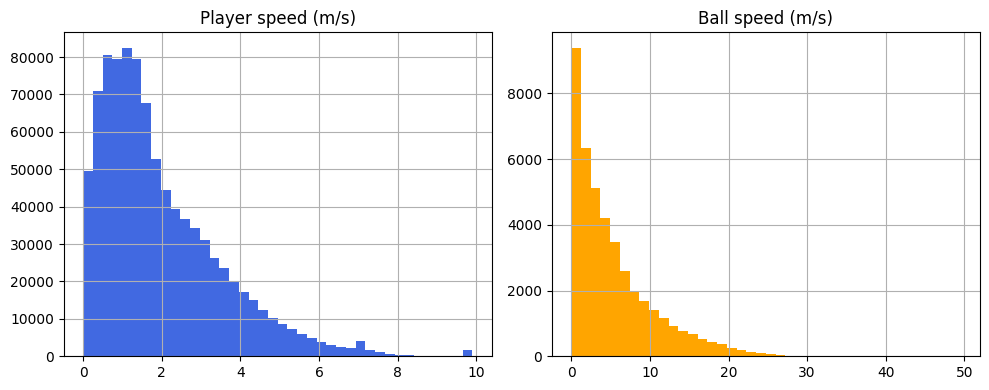

In [14]:
import matplotlib.pyplot as plt

players = df_with_vel[~df_with_vel.is_ball]
ball = df_with_vel[df_with_vel.is_ball]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

players["speed_mps"].hist(ax=ax[0], bins=40, color="royalblue")
ax[0].set_title("Player speed (m/s)")

ball["speed_mps"].hist(ax=ax[1], bins=40, color="orange")
ax[1].set_title("Ball speed (m/s)")

plt.tight_layout()
plt.show()


In [15]:
tr_ex.columns

Index(['match_id', 'time', 'frame', 'period', 'player_id', 'is_detected',
       'is_ball', 'x', 'y', 'x_rescaled', 'y_rescaled'],
      dtype='object')

In [12]:
def enrich_tracking_with_meta_gcs(tr_df: pd.DataFrame, match_id: int, fs: gcsfs.GCSFileSystem, meta_dir: str = META_DIR) -> pd.DataFrame:
    fpath = f"{meta_dir}/{match_id}.json"
    meta = read_json_gcs(fs, fpath)
    if not meta:
        # print(f"⚠️ No meta file found for match {match_id}")
        return tr_df
    home_team, away_team = meta.get("home_team", {}), meta.get("away_team", {})
    rows = []
    for p in meta.get("players", []):
        if "id" not in p:
            continue
        team = home_team if p["team_id"] == home_team.get("id") else away_team
        rows.append({
            "match_id": meta.get("id"),
            "player_id": p["id"],
            "team_id": p["team_id"],
            "team_name": team.get("name"),
            "team_short": team.get("short_name"),
            "position_group": p.get("player_role", {}).get("position_group"),
            "player_role": p.get("player_role", {}).get("name"),
            "player_short_name": p.get("short_name"),
            "is_goalkeeper": (p.get("player_role", {}).get("position_group") == "Goalkeeper")
        })
    df_meta = pd.DataFrame(rows)
    df = tr_df.merge(df_meta, on=["match_id", "player_id"], how="left", validate="m:1")
    df.loc[df["is_ball"], ["team_id", "team_name", "team_short"]] = np.nan
    return df

In [18]:
match_id = int(df_matches["id"].iloc[1])

# Assume df_with_vel contains tracking + velocities
tr_with_meta = enrich_tracking_with_meta(df_with_vel, match_id=match_id)

tr_with_meta


,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,...,vx_mps,vy_mps,speed_mps,team_id,team_name,team_short,position_group,player_role,player_short_name,is_goalkeeper
0,1715920,00:00:00.00,10,1,2816,True,False,1.03,9.46,53.539904,...,-0.403846,0.150000,0.430804,44.0,Tottenham Hotspur,Tottenham,Center Forward,Center Forward,D. Solanke,False
1,1715920,00:00:00.10,11,1,2816,True,False,0.93,9.51,53.438942,...,-0.403846,0.150000,0.430804,44.0,Tottenham Hotspur,Tottenham,Center Forward,Center Forward,D. Solanke,False
2,1715920,00:00:00.20,12,1,2816,True,False,0.85,9.54,53.358173,...,-0.403846,0.150000,0.430804,44.0,Tottenham Hotspur,Tottenham,Center Forward,Center Forward,D. Solanke,False
3,1715920,00:00:00.30,13,1,2816,True,False,0.77,9.57,53.277404,...,-0.504808,0.166667,0.531609,44.0,Tottenham Hotspur,Tottenham,Center Forward,Center Forward,D. Solanke,False
4,1715920,00:00:00.40,14,1,2816,True,False,0.70,9.59,53.206731,...,-0.572115,0.116667,0.583890,44.0,Tottenham Hotspur,Tottenham,Center Forward,Center Forward,D. Solanke,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963948,1715920,01:35:44.50,59455,2,-1,False,True,47.09,33.72,100.042788,...,-3.399038,-9.033333,9.651662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963949,1715920,01:35:44.60,59456,2,-1,False,True,46.54,32.59,99.487500,...,-4.072115,-8.466667,9.395029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963950,1715920,01:35:44.70,59457,2,-1,False,True,45.66,31.39,98.599038,...,-4.812500,-7.766667,9.136808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963951,1715920,01:35:44.80,59458,2,-1,False,True,44.69,30.00,97.619712,...,-4.593750,-6.316667,7.810430,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
tr_with_meta.columns

Index(['match_id', 'time', 'frame', 'period', 'player_id', 'is_detected',
       'is_ball', 'x', 'y', 'x_rescaled', 'y_rescaled', 'time_s', 'vx_mps',
       'vy_mps', 'speed_mps', 'team_id', 'team_name', 'team_short',
       'position_group', 'player_role', 'player_short_name', 'is_goalkeeper'],
      dtype='object')

In [20]:
tr_with_meta.player_role.unique()

array(['Center Forward', 'Left Forward', 'Defensive Midfield',
       'Left Midfield', 'Right Midfield', 'Right Center Back',
       'Left Center Back', 'Right Back', 'Goalkeeper', 'Right Forward',
       'Left Back', nan], dtype=object)

In [13]:
import matplotlib.pyplot as plt

def check_pitch_orientation(tr_with_meta: pd.DataFrame, seconds_window: float = 2.0):
    """
    Check if pitch coordinates are normalized by comparing goalkeeper positions
    around kickoffs in both halves.

    Arguments
    ---------
    tr_with_meta : pd.DataFrame
        Tracking data with rescaled positions and period info.
    seconds_window : float
        How many seconds around kickoff to average positions.
    """
    df = tr_with_meta.copy()
    fps = 10  # your dataset frame rate
    frame_window = int(seconds_window * fps)

    # --- Identify goalkeepers
    gks = df[df["player_role"] == "Goalkeeper"].copy()
    if gks.empty:
        print("⚠️ No goalkeeper roles found in metadata.")
        return

    # --- Find approximate kickoff frames per period
    kickoff_frames = (
        gks.groupby(["match_id", "period"], as_index=False)["frame"]
        .min()
        .rename(columns={"frame": "kickoff_frame"})
    )

    gks = gks.merge(kickoff_frames, on=["match_id", "period"], how="left")
    gks_window = gks[
        (gks["frame"] >= gks["kickoff_frame"]) &
        (gks["frame"] <= gks["kickoff_frame"] + frame_window)
    ].copy()

    # --- Average GK positions per team and period
    summary = (
        gks_window.groupby(["team_name", "team_short", "period"], as_index=False)
        .agg({"x_rescaled": "mean", "y_rescaled": "mean"})
    )

    # --- Visualization
    fig, ax = plt.subplots(figsize=(9, 6))
    colors = plt.cm.Set2.colors

    for i, (team, g) in enumerate(summary.groupby("team_name")):
        ax.scatter(g["x_rescaled"], g["y_rescaled"], label=f"{team}", s=120, color=colors[i % len(colors)])
        for _, r in g.iterrows():
            ax.text(r["x_rescaled"], r["y_rescaled"], f"P{r['period']}",
                    ha="center", va="center", fontsize=9, color="black")

    # --- Pitch reference
    ax.axvline(52.5, color="black", ls="--", lw=1)
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 68)
    ax.set_xlabel("Pitch X (m)")
    ax.set_ylabel("Pitch Y (m)")
    ax.set_title("Goalkeeper Positions at Kickoff (per period)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # --- Summary printout
    print("📊 Average GK X-positions by team & period:")
    print(summary.pivot(index="team_name", columns="period", values="x_rescaled").round(1))


check_pitch_orientation(tr_with_meta)



NameError: name 'tr_with_meta' is not defined

## ✅ This is exactly what happens in real matches — teams swap directions at half-time.
⚠️ But for machine learning models like SoccerMap, xT, VAEP, we need a consistent direction (always attacking left → right).

We’ll check whether our event coordinates (x_start, y_start, x_end, y_end) are
already normalized to attack direction — meaning:

the attacking team always moves left → right across the pitch (0 → 105 m).

If not, we’ll see the side swap at half-time — just like in tracking data.

In [22]:
# Choose one match
match_id = int(df_matches["id"].iloc[1])  

# Load the event data
fpath = f"{DYNAMIC_DIR}/{match_id}.parquet"

with fs.open(fpath, "rb") as f:
    events = pd.read_parquet(f)

# Filter for player possession actions only (as you said)
events = events.query("event_type == 'player_possession'").copy()

# Keep relevant columns
keep_cols = ["match_id", "period", "team_shortname", "player_name",
              "x_start", "y_start", "x_end", "y_end",
              "end_type", "attacking_side"]
#events = events[keep_cols].copy()

# Rescale from SkillCorner coordinates (-52..52, -34..34) → (0..105, 0..68)
def rescale_sc_to_fifa(x, y):
    X_MIN, X_MAX, Y_MIN, Y_MAX = -52, 52, -34, 34
    xr = (x - X_MIN) / (X_MAX - X_MIN) * 105.0
    yr = (y - Y_MIN) / (Y_MAX - Y_MIN) * 68.0
    return xr, yr

events["x_start_rescaled"], events["y_start_rescaled"] = rescale_sc_to_fifa(events["x_start"], events["y_start"])
events["x_end_rescaled"], events["y_end_rescaled"]     = rescale_sc_to_fifa(events["x_end"], events["y_end"])


## Check direction visually

We’ll plot passes from each team and each half, colored by team.
If arrows for one half point right, and the next half point left,
it means the data is not normalized.

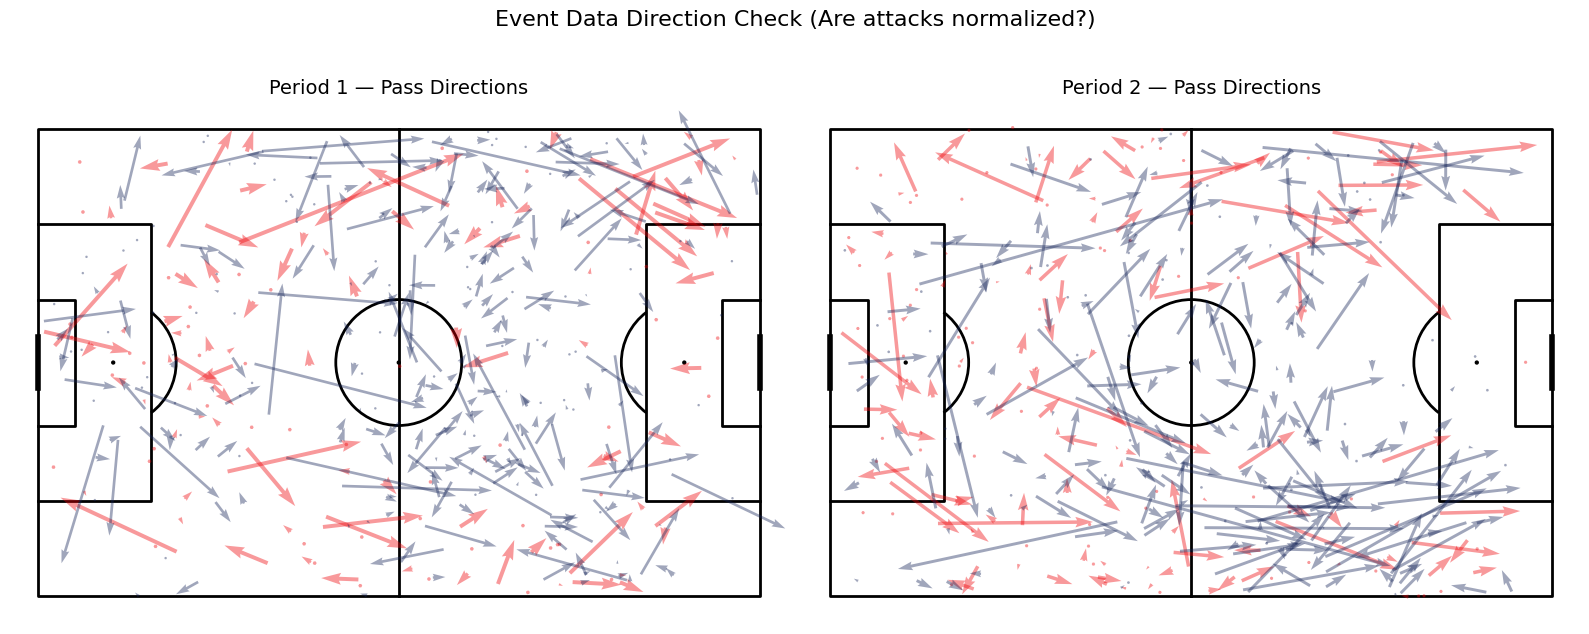

In [23]:
from mplsoccer import Pitch

def check_event_directions(events_df):
    pitch = Pitch(pitch_type='custom', pitch_length=105, pitch_width=68,
                  pitch_color='white', line_color='black')
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    colors = {"Arsenal": "#EF0107", "Tottenham": "#132257"}  # optional

    for period, ax in zip([1, 2], axes):
        pitch.draw(ax=ax)
        dfp = events_df[events_df["period"] == period]

        for team, g in dfp.groupby("team_shortname"):
            ax.quiver(g["x_start_rescaled"], g["y_start_rescaled"],
                      g["x_end_rescaled"] - g["x_start_rescaled"],
                      g["y_end_rescaled"] - g["y_start_rescaled"],
                      angles="xy", scale_units="xy", scale=1.0,
                      color=colors.get(team, "gray"), alpha=0.4)

        ax.set_title(f"Period {period} — Pass Directions", fontsize=14)

    plt.suptitle("Event Data Direction Check (Are attacks normalized?)", fontsize=16)
    plt.tight_layout()
    plt.show()
check_event_directions(events)


## quantitative check

You can also compute the mean pass Δx per team per half —
a numeric way to confirm direction:

In [24]:
events["dx"] = events["x_end_rescaled"] - events["x_start_rescaled"]

summary = (
    events.groupby(["team_shortname", "period"], as_index=False)
    .agg(mean_dx=("dx", "mean"))
    .pivot(index="team_shortname", columns="period", values="mean_dx")
)

summary.round(2)


period,1,2
team_shortname,,
Arsenal,1.21,1.75
Tottenham,1.14,3.12


Since all values are positive (for both teams and both halves):

✅ Our event data is already normalized —
i.e. every team always attacks left → right (0 → 105 m) regardless of period.

| Dataset           | Direction normalized? | Explanation                                                                   |
| ----------------- | --------------------- | ----------------------------------------------------------------------------- |
| **Tracking data** | ❌ Not normalized      | Teams switch sides each half (as in real games).                              |
| **Event data**    | ✅ Already normalized  | All actions (e.g. passes) are recorded as if the team always attacks → right. |


When we merge event + tracking data (for SoccerMap training):

We’ll need to flip the tracking data to match event normalization.
(so that possession team always attacks left → right).

We don’t need to modify the event coordinates —
they’re already good for input labels (target pass location etc.).

In [25]:
events.attacking_side.value_counts()

attacking_side
right_to_left    476
left_to_right    391
Name: count, dtype: int64

## Merge event to tracking

In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def merge_tracking_and_events(match_id: int, df_events: pd.DataFrame, df_tracking: pd.DataFrame) -> pd.DataFrame:
    """
    Merge tracking data with event info so each pass start frame inherits:
      - team_in_possession
      - attacking_side
      - player_in_possession_id
      - pass outcome + coordinates (rescaled)
      - labels such as lead_to_goal if present
    
    Only uses the *start frame* of each pass event, since SoccerMap learns from
    the player/ball configuration before the pass.
    """
    frames_all = []

    # ✅ Keep only pass possessions (successful / unsuccessful)
    df_events_pass = df_events.query(
        "event_type == 'player_possession' and end_type == 'pass'"
    ).copy()

    if df_events_pass.empty:
        print(f"⚠️ No valid pass events for match {match_id}")
        return pd.DataFrame()

    for _, ev in tqdm(df_events_pass.iterrows(), total=len(df_events_pass), desc=f"Merging match {match_id}"):
        frame_start = int(ev["frame_start"]) if "frame_start" in ev else None
        if frame_start is None or frame_start not in df_tracking["frame"].values:
            continue

        # take only the frame at the start of the pass
        tr_slice = df_tracking.loc[df_tracking["frame"] == frame_start].copy()
        if tr_slice.empty:
            continue

        # Assign event info (broadcast to all players + ball in that frame)
        tr_slice["event_id"] = ev.get("event_id")
        tr_slice["event_type"] = ev.get("event_type")
        tr_slice["end_type"] = ev.get("end_type")
        tr_slice["pass_outcome"] = ev.get("pass_outcome", None)
        tr_slice["player_in_possession_id"] = ev.get("player_in_possession_id", ev.get("player_id", None))
        tr_slice["team_in_possession"] = ev.get("team_id")
        tr_slice["team_in_possession_shortname"] = ev.get("team_shortname")
        tr_slice["attacking_side"] = ev.get("attacking_side")
        tr_slice["period"] = ev.get("period")

        # --- Pass start and end coordinates ---
        for c in ["x_start_rescaled", "y_start_rescaled", "x_end_rescaled", "y_end_rescaled"]:
            if c in ev:
                tr_slice[c] = ev[c]

        # --- Add label columns if available (e.g. for model training) ---
        for label_col in ["lead_to_goal", "lead_to_shot", "lead_to_box_entry"]:
            if label_col in ev:
                tr_slice[label_col] = ev[label_col]

        frames_all.append(tr_slice)

    if not frames_all:
        print(f"⚠️ No matching frames for match {match_id}")
        return pd.DataFrame()

    df_merged = pd.concat(frames_all, ignore_index=True)

    # --- Clean up ---
    df_merged["match_id"] = match_id
    df_merged = df_merged.sort_values(["period", "frame"]).reset_index(drop=True)

    #print(f"✅ [match {match_id}] merged frames: {len(df_merged):,}")
    return df_merged


In [27]:
events= load_events_basic(int(df_matches["id"].iloc[1]))

[match 1715920] passes: 785 | cols: 186
Non-null ratio: 90.69%


In [28]:
freeze_frame= merge_tracking_and_events(int(df_matches["id"].iloc[1]) , events, tr_with_meta)
freeze_frame

Merging match 1715920: 100%|██████████| 785/785 [00:03<00:00, 227.27it/s]


,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,...,player_in_possession_id,team_in_possession,team_in_possession_shortname,attacking_side,x_start_rescaled,y_start_rescaled,x_end_rescaled,y_end_rescaled,lead_to_goal,lead_to_shot
0,1715920,00:00:01.70,27,1,2816,True,False,-0.30,9.18,52.197115,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
1,1715920,00:00:01.70,27,1,4314,True,False,0.75,-19.06,53.257212,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
2,1715920,00:00:01.70,27,1,5365,True,False,0.14,-0.54,52.641346,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
3,1715920,00:00:01.70,27,1,6109,True,False,-0.09,-13.47,52.409135,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
4,1715920,00:00:01.70,27,1,10324,True,False,-5.96,-9.26,46.482692,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18050,1715920,01:35:40.40,59414,2,32567,False,False,15.16,-3.37,67.805769,...,12286,3,Arsenal,right_to_left,11.509615,18.64,4.018269,17.38,False,False
18051,1715920,01:35:40.40,59414,2,38008,True,False,37.62,18.60,90.481731,...,12286,3,Arsenal,right_to_left,11.509615,18.64,4.018269,17.38,False,False
18052,1715920,01:35:40.40,59414,2,70576,True,False,33.27,-6.84,86.089904,...,12286,3,Arsenal,right_to_left,11.509615,18.64,4.018269,17.38,False,False
18053,1715920,01:35:40.40,59414,2,288468,True,False,32.17,18.24,84.979327,...,12286,3,Arsenal,right_to_left,11.509615,18.64,4.018269,17.38,False,False


In [29]:
freeze_frame.columns

Index(['match_id', 'time', 'frame', 'period', 'player_id', 'is_detected',
       'is_ball', 'x', 'y', 'x_rescaled', 'y_rescaled', 'time_s', 'vx_mps',
       'vy_mps', 'speed_mps', 'team_id', 'team_name', 'team_short',
       'position_group', 'player_role', 'player_short_name', 'is_goalkeeper',
       'event_id', 'event_type', 'end_type', 'pass_outcome',
       'player_in_possession_id', 'team_in_possession',
       'team_in_possession_shortname', 'attacking_side', 'x_start_rescaled',
       'y_start_rescaled', 'x_end_rescaled', 'y_end_rescaled', 'lead_to_goal',
       'lead_to_shot'],
      dtype='object')

In [30]:
freeze_frame[freeze_frame['frame']== 27]

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,...,player_in_possession_id,team_in_possession,team_in_possession_shortname,attacking_side,x_start_rescaled,y_start_rescaled,x_end_rescaled,y_end_rescaled,lead_to_goal,lead_to_shot
0,1715920,00:00:01.70,27,1,2816,True,False,-0.30,9.18,52.197115,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
1,1715920,00:00:01.70,27,1,4314,True,False,0.75,-19.06,53.257212,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
2,1715920,00:00:01.70,27,1,5365,True,False,0.14,-0.54,52.641346,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
3,1715920,00:00:01.70,27,1,6109,True,False,-0.09,-13.47,52.409135,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
4,1715920,00:00:01.70,27,1,10324,True,False,-5.96,-9.26,46.482692,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
5,1715920,00:00:01.70,27,1,11287,True,False,10.89,-9.46,63.494712,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
6,1715920,00:00:01.70,27,1,12115,True,False,2.56,-11.23,55.084615,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
7,1715920,00:00:01.70,27,1,12286,True,False,-13.00,-7.19,39.375000,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
8,1715920,00:00:01.70,27,1,12485,True,False,0.58,-18.46,53.085577,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False
9,1715920,00:00:01.70,27,1,12841,True,False,-8.89,5.36,43.524519,...,5365,3,Arsenal,left_to_right,52.641346,33.46,52.641346,33.46,False,False


## Attack Direction Normalization
That’s the key idea:

Normalize so that the team in possession is always attacking left → right.

In [15]:
def normalize_tracking_direction(df_merged: pd.DataFrame) -> pd.DataFrame:
    """
    Flip coordinates so that team_in_possession always attacks left -> right.
    """
    df_norm = df_merged.copy()

    mask = df_norm["attacking_side"] == "right_to_left"
    df_norm.loc[mask, "x_rescaled"] = 105.0 - df_norm.loc[mask, "x_rescaled"]
    df_norm.loc[mask, "y_rescaled"] = 68.0 - df_norm.loc[mask, "y_rescaled"]
    df_norm.loc[mask, "vx_mps"] = -df_norm.loc[mask, "vx_mps"]
    df_norm.loc[mask, "vy_mps"] = -df_norm.loc[mask, "vy_mps"]

    return df_norm


In [32]:
# Merge and normalize
merged = merge_tracking_and_events(match_id, events, tr_with_meta)
normed = normalize_tracking_direction(merged)


Merging match 1715920: 100%|██████████| 785/785 [00:03<00:00, 223.78it/s]


In [33]:
normed.columns

Index(['match_id', 'time', 'frame', 'period', 'player_id', 'is_detected',
       'is_ball', 'x', 'y', 'x_rescaled', 'y_rescaled', 'time_s', 'vx_mps',
       'vy_mps', 'speed_mps', 'team_id', 'team_name', 'team_short',
       'position_group', 'player_role', 'player_short_name', 'is_goalkeeper',
       'event_id', 'event_type', 'end_type', 'pass_outcome',
       'player_in_possession_id', 'team_in_possession',
       'team_in_possession_shortname', 'attacking_side', 'x_start_rescaled',
       'y_start_rescaled', 'x_end_rescaled', 'y_end_rescaled', 'lead_to_goal',
       'lead_to_shot'],
      dtype='object')

In [16]:
import traceback
from pathlib import Path

def process_and_save_match_gcs(match_id: int) -> int:
    fs = gcsfs.GCSFileSystem()  # each worker creates its own instance (fork-safe)
    try:
        outpath = f"{SOCCERMAP_FRAMES_DIR3}/{match_id}_normed.parquet"
        if fs.exists(outpath):
            # already processed
            return match_id

        # 1) load base data
        tr = load_tracking_full_gcs(match_id, fs)
        ev = load_events_basic_gcs(match_id, fs)
        meta = load_meta_mapping_gcs(match_id, fs)

        if tr is None or ev is None or meta is None or tr.empty or ev.empty or meta.empty:
            # skip if any missing
            # print(f"⚠️ Skipped {match_id} (missing one of: tracking, events, meta)")
            return match_id

        # 2) compute velocities (user function)
        tr = compute_all_velocities(tr)

        # 3) add meta
        tr = enrich_tracking_with_meta_gcs(tr, match_id, fs)

        # 4) merge with events
        df_merged = merge_tracking_and_events(match_id, ev, tr)

        # 5) normalize direction
        df_normed = normalize_tracking_direction(df_merged)

        # 6) sanity & write
        if df_normed[["x_rescaled", "y_rescaled"]].isna().all().any():
            raise ValueError("Missing rescaled coordinates after normalization.")

        # write to GCS (pandas + fsspec should handle it)
        write_parquet_gcs(df_normed, outpath)
        return match_id

    except Exception as e:
        # log error but don't crash the pool
        print(f"❌ Error processing {match_id}: {e}")
        traceback.print_exc()
        return match_id

In [56]:
MAX_WORKERS = min(28, (os.cpu_count() or 32) - 1)

In [63]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [66]:
def run_parallel_threaded(match_ids, max_workers=28):

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_and_save_match_gcs, mid) for mid in match_ids]

        for f in tqdm(as_completed(futures), total=len(futures), desc="matches"):
            f.result()  # récupère l'erreur si crash, sinon ignore

In [ ]:
run_parallel_threaded(df_matches["id"].unique(), max_workers=32)

Merging match 1666921:  77%|███████▋  | 710/922 [00:58<00:53,  3.97it/s]

Merging match 1666921:  77%|███████▋  | 712/922 [00:58<00:45,  4.65it/s]

Merging match 1666921:  77%|███████▋  | 713/922 [00:58<00:42,  4.87it/s]

Merging match 1666921:  77%|███████▋  | 714/922 [00:58<00:39,  5.20it/s]

Merging match 1666921:  78%|███████▊  | 715/922 [00:59<00:36,  5.72it/s]

Merging match 1666921:  78%|███████▊  | 716/922 [00:59<00:34,  6.05it/s]

Merging match 1666921:  78%|███████▊  | 717/922 [01:01<02:53,  1.18it/s]

Merging match 1666921:  78%|███████▊  | 718/922 [01:01<02:11,  1.55it/s]

Merging match 1666921:  78%|███████▊  | 721/922 [01:02<01:03,  3.19it/s]

Merging match 1729518:   1%|          | 10/868 [00:04<07:46,  1.84it/s]

Merging match 1666921:  79%|███████▊  | 724/922 [01:03<01:34,  2.10it/s]

Merging match 1666921:  79%|███████▊  | 725/922 [01:04<01:38,  2.01it/s]

Merging match 1729518:   1%|▏         | 13/868 [00:06<08:54,  1.60it/s]

Merging match 1666921:  79%|███████▉  | 

# Overview of SoccerMap Input Channels

Each frame of the game is converted into multi-channel 2D tensors representing the state of the pitch.


| Channel Group                       | Type       | Description                                                                                                           |
| ----------------------------------- | ---------- | --------------------------------------------------------------------------------------------------------------------- |
| (1–6) Player location/velocity      | **Sparse** | x,y-positions and (vx,vy) velocity for all players in the **attacking** and **defending** teams (3 × 2 = 6 channels). |
| (7–8) Distance maps                 | **Dense**  | Distance from each grid point to the **ball** and **goal**.                                                           |
| (9–11) Angle maps                   | **Dense**  | Sine, cosine, and raw angle (radians) from each grid point to the **goal** (and optionally to ball).                  |
| (12–13) Ball-carrier velocity angle | **Sparse** | Sine and cosine of the **angle between the ball-carrier’s velocity** and each teammate’s velocity.                    |


We’ll use a pitch grid of (105, 68) (1 m per pixel).

In [17]:
import numpy as np
import pandas as pd

PITCH_LENGTH = 105
PITCH_WIDTH = 68
GOAL_CENTER = np.array([105.0, 34.0])  # attacking goal at right edge

def create_pitch_grid(length=PITCH_LENGTH, width=PITCH_WIDTH):
    """Return X,Y meshgrid for pitch coordinates."""
    y = np.linspace(0, width, width)
    x = np.linspace(0, length, length)
    return np.meshgrid(x, y)


# Sparse Channels: Player locations & velocities

In [18]:
def make_sparse_player_channels(df_frame, attacking_team, defending_team):
    """
    Create 6 sparse channels (3 per team):
      - Attacking: location mask, vx, vy
      - Defending: location mask, vx, vy
    Each channel has shape (68, 105).
    """
    pitch_h, pitch_w = int(PITCH_WIDTH), int(PITCH_LENGTH)
    att_ch = np.zeros((3, pitch_h, pitch_w))
    def_ch = np.zeros((3, pitch_h, pitch_w))

    for _, row in df_frame.iterrows():
        if pd.isna(row["x_rescaled"]) or pd.isna(row["y_rescaled"]):
            continue

        x = int(np.clip(round(row["x_rescaled"]), 0, pitch_w - 1))
        y = int(np.clip(round(row["y_rescaled"]), 0, pitch_h - 1))
        vx, vy = row.get("vx_mps", 0.0), row.get("vy_mps", 0.0)

        if row["team_short"] == attacking_team and not row["is_ball"]:
            att_ch[0, y, x] = 1.0
            att_ch[1, y, x] = vx
            att_ch[2, y, x] = vy

        elif row["team_short"] == defending_team and not row["is_ball"]:
            def_ch[0, y, x] = 1.0
            def_ch[1, y, x] = vx
            def_ch[2, y, x] = vy

    return att_ch, def_ch


# Dense Distance and Angle Maps

In [19]:
def make_distance_maps(ball_pos):
    """Dense maps: distance to ball and to goal center."""
    X, Y = create_pitch_grid()
    dist_ball = np.sqrt((X - ball_pos[0])**2 + (Y - ball_pos[1])**2)
    dist_goal = np.sqrt((X - GOAL_CENTER[0])**2 + (Y - GOAL_CENTER[1])**2)
    return dist_ball, dist_goal


import numpy as np

PITCH_LENGTH = 105
PITCH_WIDTH = 68
GOAL_Y_TOP = 34 + 7.32 / 2
GOAL_Y_BOTTOM = 34 - 7.32 / 2
GOAL_X = 105.0  # attacking goal line

def make_angle_maps(ball_pos=None):
    """
    Create dense maps for:
    - sin(angle_to_goal)
    - cos(angle_to_goal)
    - open angle_to_goal (radians)
    
    Each grid cell (x, y) gets its *open shot angle* to the two goalposts.

    This represents how wide the goal looks from that point, independent of ball position.
    """
    X, Y = create_pitch_grid()  # shape (68, 105)

    # Compute distances to top and bottom goalposts
    top_dx = GOAL_X - X
    top_dy = GOAL_Y_TOP - Y
    bot_dx = GOAL_X - X
    bot_dy = GOAL_Y_BOTTOM - Y

    # Angles to each post
    top_angle = np.arctan2(top_dy, top_dx)
    bot_angle = np.arctan2(bot_dy, bot_dx)

    # Open goal angle = absolute difference between them
    angle_open = np.abs(top_angle - bot_angle)

    # Clip to π (safety for numerical stability)
    angle_open = np.clip(angle_open, 0, np.pi)

    # Sin/Cos maps (useful for continuous model features)
    sin_map = np.sin(angle_open)
    cos_map = np.cos(angle_open)

    return sin_map, cos_map, angle_open




| Area on pitch    | Open angle (radians) | Meaning                      |
| ---------------- | -------------------- | ---------------------------- |
| Center near goal | Large (≈ 3.14)       | Full view of goal            |
| Far wide areas   | Small                | Narrow shooting lane         |
| Midfield         | Tiny                 | Very limited goal visibility |


# Ball-Carrier Velocity–Angle Maps

In [20]:
def make_velocity_angle_channels(df_frame, ball_carrier_id):
    """
    Two sparse maps (sin, cos of angle between ball-carrier velocity
    and each teammate’s velocity vector).
    """
    pitch_h, pitch_w = int(PITCH_WIDTH), int(PITCH_LENGTH)
    sin_ch = np.zeros((pitch_h, pitch_w))
    cos_ch = np.zeros((pitch_h, pitch_w))

    # Find ball carrier and their velocity
    carrier = df_frame[df_frame["player_id"] == ball_carrier_id]
    if carrier.empty:
        return sin_ch, cos_ch

    vx_c, vy_c = carrier["vx_mps"].iloc[0], carrier["vy_mps"].iloc[0]
    norm_c = np.hypot(vx_c, vy_c)
    if norm_c < 1e-6:
        return sin_ch, cos_ch

    for _, row in df_frame.iterrows():
        if pd.isna(row["x_rescaled"]) or pd.isna(row["y_rescaled"]) or row["is_ball"]:
            continue
        if row["player_id"] == ball_carrier_id:
            continue

        x = int(np.clip(round(row["x_rescaled"]), 0, pitch_w - 1))
        y = int(np.clip(round(row["y_rescaled"]), 0, pitch_h - 1))
        vx, vy = row.get("vx_mps", 0.0), row.get("vy_mps", 0.0)

        norm_t = np.hypot(vx, vy)
        if norm_t < 1e-6:
            continue

        dot = (vx * vx_c + vy * vy_c) / (norm_c * norm_t)
        dot = np.clip(dot, -1, 1)
        angle = np.arccos(dot)

        sin_ch[y, x] = np.sin(angle)
        cos_ch[y, x] = np.cos(angle)

    return sin_ch, cos_ch


# Assemble the Full SoccerMap Tensor

In [21]:
def generate_soccer_map_channels(df_frame, attacking_team, defending_team, ball_carrier_id, ball_pos):
    """
    Combine all 13 channels:
      6 sparse (att+def),
      2 dense (distances),
      3 dense (angles),
      2 sparse (velocity-angle).
    Output shape: (13, 68, 105)
    """
    att_ch, def_ch = make_sparse_player_channels(df_frame, attacking_team, defending_team)
    dist_ball, dist_goal = make_distance_maps(ball_pos)
    sin_goal, cos_goal, angle_goal = make_angle_maps(ball_pos)
    sin_vel, cos_vel = make_velocity_angle_channels(df_frame, ball_carrier_id)

    tensor = np.stack([
        *att_ch, *def_ch,              # 6 sparse
        dist_ball, dist_goal,          # 2 dense
        sin_goal, cos_goal, angle_goal,# 3 dense
        sin_vel, cos_vel               # 2 sparse
    ], axis=0)
    return tensor


In [27]:
match_id = df_matches.iloc[0]['id']

In [30]:
match_id

1986708

In [31]:
fpath = f"{SOCCERMAP_FRAMES_DIR3}/{match_id}_normed.parquet"
normed = read_parquet_gcs(fs, fpath).copy()

In [32]:
normed

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,...,player_in_possession_id,team_in_possession,team_in_possession_shortname,attacking_side,x_start_rescaled,y_start_rescaled,x_end_rescaled,y_end_rescaled,lead_to_goal,lead_to_shot
0,1986708,00:00:00.10,11,1,4881,True,False,-8.70,2.94,43.716346,...,18686,60,Crystal Palace,left_to_right,52.681731,34.21,52.681731,34.21,False,False
1,1986708,00:00:00.10,11,1,11274,True,False,1.07,-14.74,53.580288,...,18686,60,Crystal Palace,left_to_right,52.681731,34.21,52.681731,34.21,False,False
2,1986708,00:00:00.10,11,1,12454,True,False,-5.42,-9.44,47.027885,...,18686,60,Crystal Palace,left_to_right,52.681731,34.21,52.681731,34.21,False,False
3,1986708,00:00:00.10,11,1,12577,True,False,10.04,-0.59,62.636538,...,18686,60,Crystal Palace,left_to_right,52.681731,34.21,52.681731,34.21,False,False
4,1986708,00:00:00.10,11,1,12629,True,False,3.08,15.15,55.609615,...,18686,60,Crystal Palace,left_to_right,52.681731,34.21,52.681731,34.21,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15451,1986708,01:40:11.80,60218,2,24638,False,False,-26.89,-1.72,NaN,...,19054,754,Brentford FC,left_to_right,14.609135,37.55,16.325481,34.98,False,False
15452,1986708,01:40:11.80,60218,2,29537,False,False,0.68,4.42,NaN,...,19054,754,Brentford FC,left_to_right,14.609135,37.55,16.325481,34.98,False,False
15453,1986708,01:40:11.80,60218,2,32267,False,False,-0.45,20.43,NaN,...,19054,754,Brentford FC,left_to_right,14.609135,37.55,16.325481,34.98,False,False
15454,1986708,01:40:11.80,60218,2,487156,False,False,-19.81,14.94,NaN,...,19054,754,Brentford FC,left_to_right,14.609135,37.55,16.325481,34.98,False,False


In [36]:
frame_df = normed.query("frame == 60218")  # one pass start frame
att_team = frame_df["team_in_possession_shortname"].iloc[0]
def_team = frame_df["team_short"].loc[frame_df["team_short"] != att_team].iloc[0]
ball_carrier = frame_df["player_in_possession_id"].iloc[0]
ball_pos = frame_df.query("is_ball == True")[["x_rescaled", "y_rescaled"]].iloc[0].values

tensor = generate_soccer_map_channels(frame_df, att_team, def_team, ball_carrier, ball_pos)
print("SoccerMap tensor shape:", tensor.shape)  # (13, 68, 105)


SoccerMap tensor shape: (13, 68, 105)


In [37]:
import matplotlib.pyplot as plt

def visualize_soccer_map_tensor(tensor: np.ndarray,
                                attacking_team: str,
                                defending_team: str,
                                frame_df: pd.DataFrame,
                                figsize=(18, 12)) -> None:
    """
    Visualize all 13 SoccerMap input channels (6 sparse + 7 dense).
    """
    ch_names = [
        f"{attacking_team} loc", f"{attacking_team} vx", f"{attacking_team} vy",
        f"{defending_team} loc", f"{defending_team} vx", f"{defending_team} vy",
        "Dist → Ball", "Dist → Goal",
        "Sin(Goal Angle)", "Cos(Goal Angle)", "Angle → Goal",
        "Sin(Vel Angle)", "Cos(Vel Angle)"
    ]

    n_ch = tensor.shape[0]
    ncols, nrows = 5, int(np.ceil(n_ch / 5))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for i in range(n_ch):
        ax = axes[i]
        im = ax.imshow(tensor[i], origin="lower", extent=[0, 105, 0, 68], cmap="coolwarm")
        ax.set_title(ch_names[i], fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)

    # Remove unused subplots
    for j in range(n_ch, len(axes)):
        fig.delaxes(axes[j])

    # Add metadata title
    frame_num = frame_df["frame"].iloc[0]
    event_id = frame_df["event_id"].iloc[0]
    pass_outcome = frame_df.get("pass_outcome", pd.Series(["NA"])).iloc[0]
    lead_to_goal = frame_df.get("lead_to_goal", pd.Series([False])).iloc[0]

    fig.suptitle(
        f"Frame {frame_num} | Event {event_id} | Outcome: {pass_outcome} | Lead to Goal: {lead_to_goal}",
        fontsize=14, y=0.95
    )
    plt.tight_layout()
    plt.show()


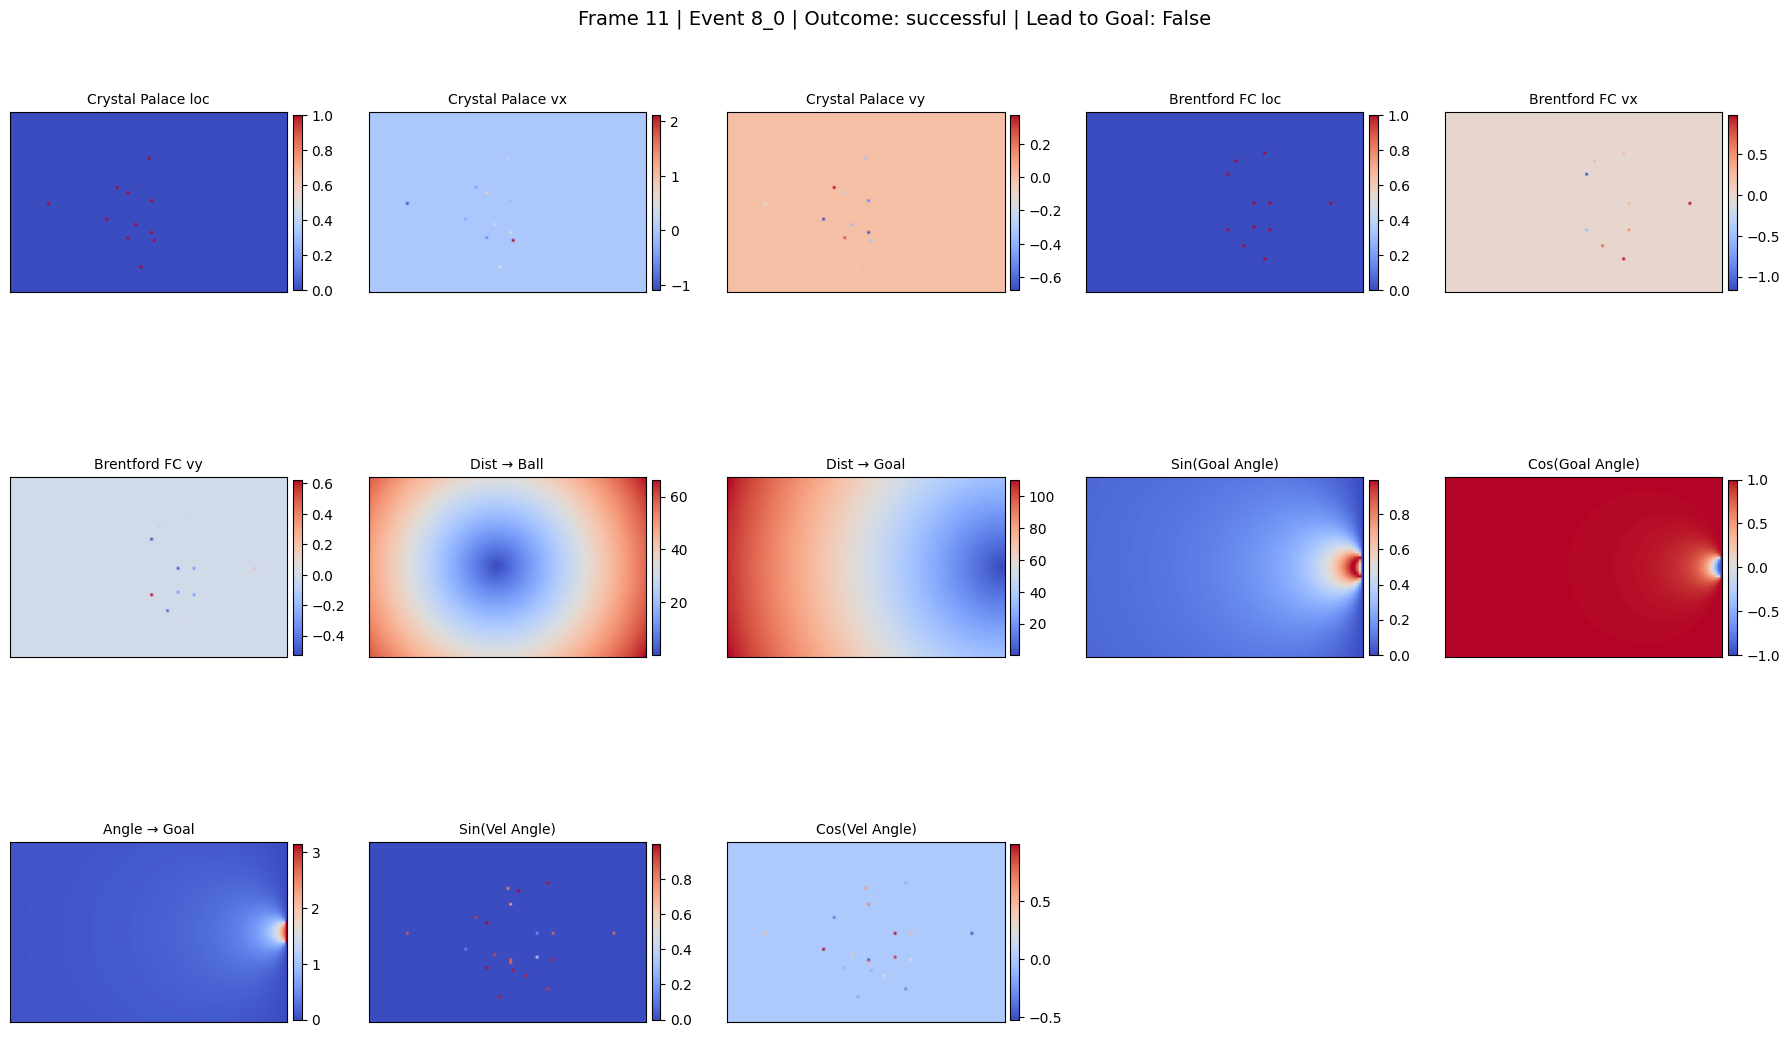

In [38]:
frame_df = normed.query("frame == 11")
att_team = frame_df["team_in_possession_shortname"].iloc[0]
def_team = frame_df["team_short"].loc[frame_df["team_short"] != att_team].iloc[0]
ball_carrier = frame_df["player_in_possession_id"].iloc[0]
ball_pos = frame_df.query("is_ball == True")[["x_rescaled","y_rescaled"]].iloc[0].values

tensor = generate_soccer_map_channels(frame_df, att_team, def_team, ball_carrier, ball_pos)
visualize_soccer_map_tensor(tensor, att_team, def_team, frame_df)


In [39]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_soccer_map_tensor_with_pitch(tensor: np.ndarray,
                                           attacking_team: str,
                                           defending_team: str,
                                           frame_df: pd.DataFrame,
                                           figsize=(20, 12)) -> None:
    """
    Visualize all 13 SoccerMap input channels (6 sparse + 7 dense)
    over a football pitch background using mplsoccer.
    """
    ch_names = [
        f"{attacking_team} loc", f"{attacking_team} vx", f"{attacking_team} vy",
        f"{defending_team} loc", f"{defending_team} vx", f"{defending_team} vy",
        "Dist → Ball", "Dist → Goal",
        "Sin(Goal Angle)", "Cos(Goal Angle)", "Angle → Goal",
        "Sin(Vel Angle)", "Cos(Vel Angle)"
    ]

    n_ch = tensor.shape[0]
    ncols, nrows = 5, int(np.ceil(n_ch / 5))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    # Pitch configuration
    pitch = Pitch(pitch_type='custom', pitch_length=105, pitch_width=68, line_color='gray')

    for i in range(n_ch):
        ax = axes[i]
        pitch.draw(ax=ax)
        im = ax.imshow(tensor[i], origin="lower", extent=[0, 105, 0, 68],
                       cmap="coolwarm", alpha=0.8)
        ax.set_title(ch_names[i], fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02)

    # Remove unused subplots
    for j in range(n_ch, len(axes)):
        fig.delaxes(axes[j])

    # Add metadata
    frame_num = frame_df["frame"].iloc[0]
    event_id = frame_df["event_id"].iloc[0]
    pass_outcome = frame_df.get("pass_outcome", pd.Series(["NA"])).iloc[0]
    lead_to_goal = frame_df.get("lead_to_goal", pd.Series([False])).iloc[0]

    fig.suptitle(
        f"Frame {frame_num} | Event {event_id} | Outcome: {pass_outcome} | Lead to Goal: {lead_to_goal}",
        fontsize=14, y=0.95
    )
    plt.tight_layout()
    plt.show()


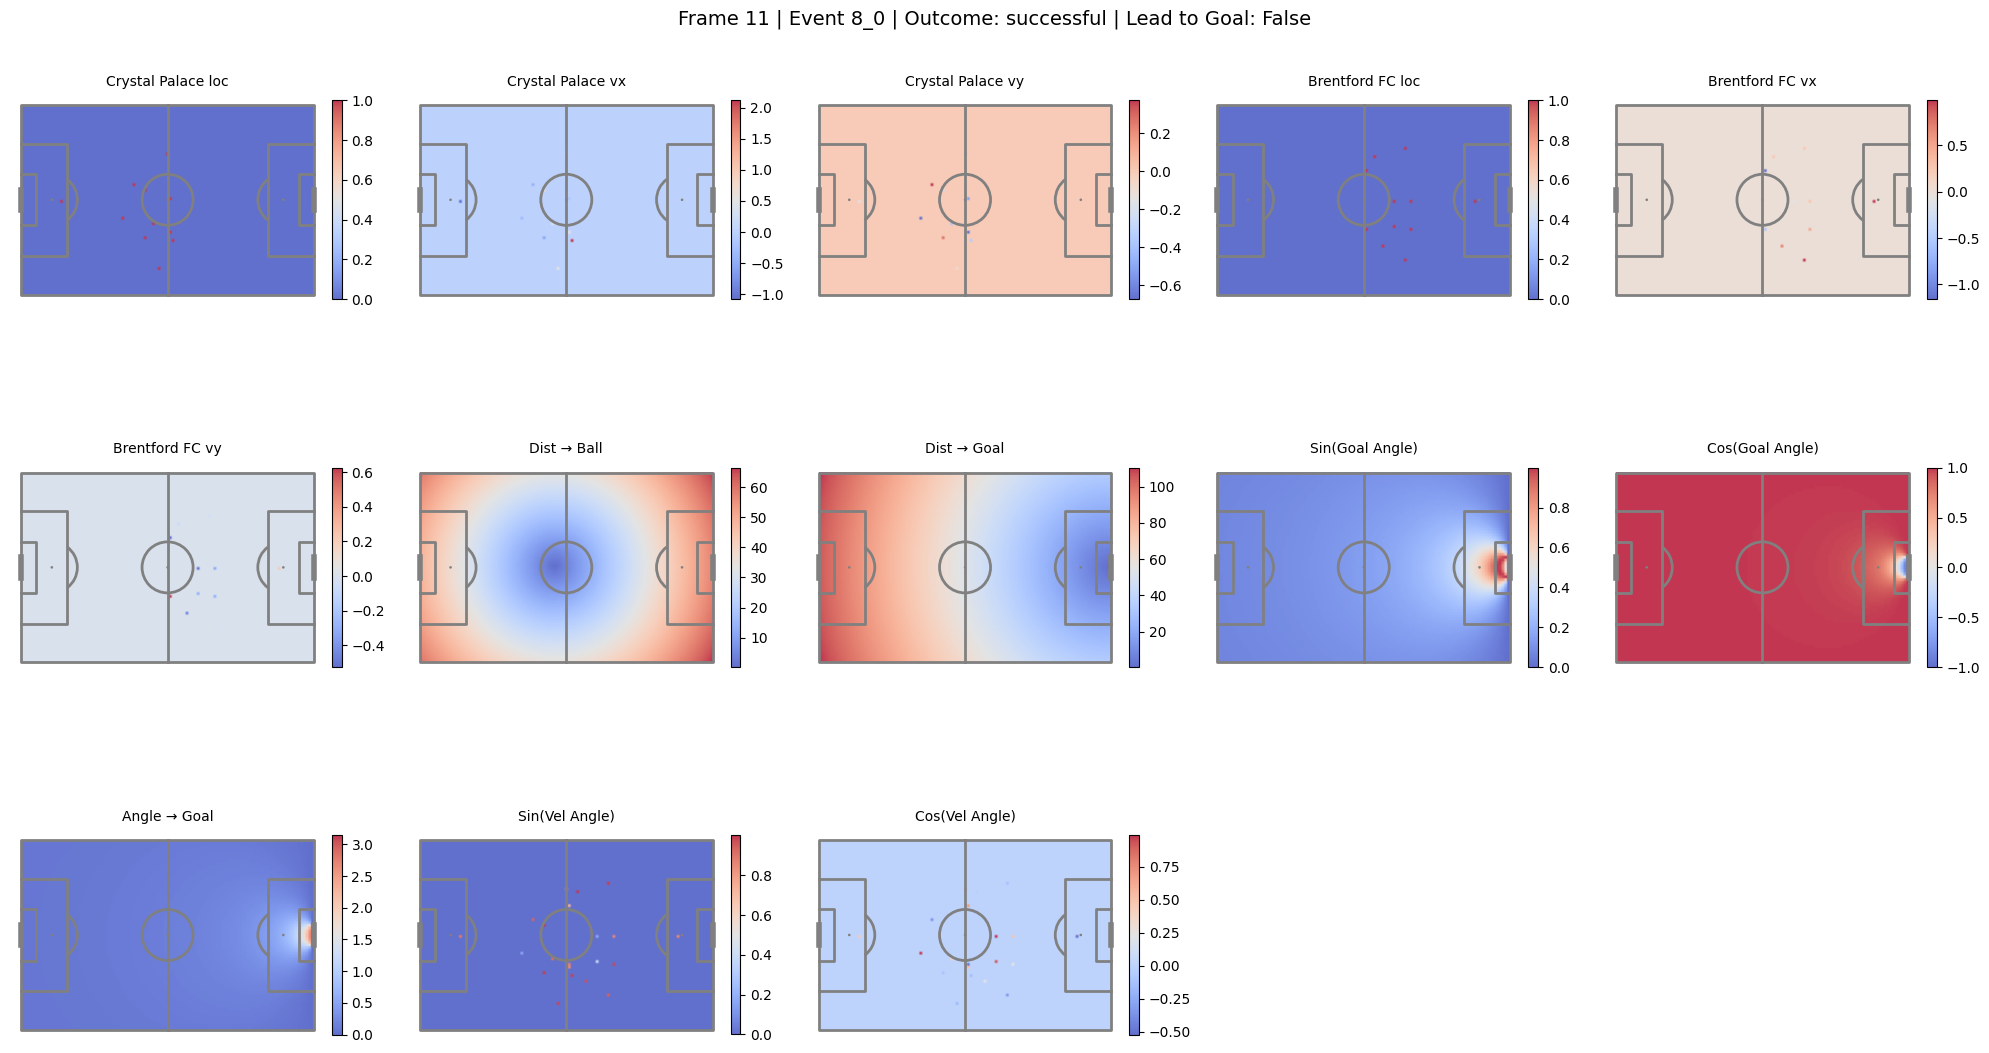

In [40]:
frame_df = normed.query("frame == 11")
att_team = frame_df["team_in_possession_shortname"].iloc[0]
def_team = frame_df["team_short"].loc[frame_df["team_short"] != att_team].iloc[0]
ball_carrier = frame_df["player_in_possession_id"].iloc[0]
ball_pos = frame_df.query("is_ball == True")[["x_rescaled","y_rescaled"]].iloc[0].values

tensor = generate_soccer_map_channels(frame_df, att_team, def_team, ball_carrier, ball_pos)
visualize_soccer_map_tensor_with_pitch(tensor, att_team, def_team, frame_df)


In [41]:
normed.pass_outcome.value_counts()

pass_outcome
successful      11385
unsuccessful     4048
offside            23
Name: count, dtype: int64

# Label generation:

The goal:

- X_tensor   → 13-channel SoccerMap input (player & ball spatial state)

- mask       → binary 68×105 array, 1 at (x_end, y_end)

- y          → 1 if successful, 0 if unsuccessful

That’s all we need to train with binary cross-entropy between
f(x)_mask (the model’s predicted probability at the true pass target)
and the true label y.


In [349]:
import sys
!{sys.executable} -m pip install torch


  Using cached torch-2.9.0-cp311-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.9.0-cp311-none-macosx_11_0_arm64.whl (74.5 MB)
Using cached fsspec-2025.10.0-py3-none-any.whl (200 kB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached filelock-3.20.0-py3-none-any.whl (16 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [torch]32m4/5 [torch]]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [355]:
!{sys.executable} -m pip install torch pytorch_lightning

  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached frozenlist-1.8.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached multidict-6.7.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.3 kB)
  Using cached propcache-0.4.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached yarl-1.22.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (75 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 2.0 MB/s  0:00:0036m-:--:--
Using cached multidict-6.7.0-cp311-cp311-macosx_11_0_arm64.whl (44 kB)
Using cached yarl-1.22.0-cp311-cp311-macosx_11_0_arm64.whl (94 kB)
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cached aiosignal-1.4.0-py3-none-any.whl (7.5 kB)
Using cached frozenlist-1.8.0-cp311-cp311-macosx_11_0_arm64.whl (50 kB)
Using cached propcache-0.4.1-cp311-cp311-macosx_11_0_arm64.whl (47 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/9

# Big Picture Pipeline

We are training three weakly supervised spatial classifiers, each predicting a scalar label at one grid location:

| Model                      | What it predicts     | Label column         | Mask location                      |
| -------------------------- | -------------------- | -------------------- | ---------------------------------- |
| **Pass Success Surface**   | p(successful pass)   | `pass_outcome`       | `(x_end_rescaled, y_end_rescaled)` |
| **Pass Selection Surface** | where ball is passed | implicit (mask only) | `(x_end_rescaled, y_end_rescaled)` |
| **xT Surface**             | p(goal within 10s)   | `lead_to_goal`       | `(x_end_rescaled, y_end_rescaled)` |


- Each input = 13-channel tensor (players, distances, angles, etc.).
- Each label = 1 scalar (binary).
- Each mask = 1 at true pass destination, shape (1, 68, 105).

##  Preparation for pass success

In [22]:
import numpy as np
import torch

PITCH_LENGTH = 105
PITCH_WIDTH = 68

class ToSoccerMapPassSuccessTensor:
    """Convert one pass event (row) to a dense 13×68×105 SoccerMap tensor."""

    def __init__(self, dim=(68, 105)):
        self.y_bins, self.x_bins = dim

    def _get_cell_indexes(self, x, y):
        x_bin = np.clip(x / PITCH_LENGTH * self.x_bins, 0, self.x_bins - 1).astype(int)
        y_bin = np.clip(y / PITCH_WIDTH * self.y_bins, 0, self.y_bins - 1).astype(int)
        return x_bin, y_bin

    def __call__(self, row: pd.Series):
        start_x, start_y = row["x_start_rescaled"], row["y_start_rescaled"]
        end_x, end_y = row["x_end_rescaled"], row["y_end_rescaled"]
        target = float(row.get("success", 0.0))

        matrix = np.zeros((13, self.y_bins, self.x_bins), dtype=np.float32)
        yy, xx = np.meshgrid(np.arange(self.y_bins), np.arange(self.x_bins), indexing="ij")

        # convert grid to meters
        xx_m = xx / self.x_bins * PITCH_LENGTH
        yy_m = yy / self.y_bins * PITCH_WIDTH

        # --- Channel 0–1: Start & End locations
        x_start_bin, y_start_bin = self._get_cell_indexes(np.array([start_x]), np.array([start_y]))
        x_end_bin, y_end_bin = self._get_cell_indexes(np.array([end_x]), np.array([end_y]))
        matrix[0, y_start_bin, x_start_bin] = 1.0
        matrix[1, y_end_bin, x_end_bin] = 1.0

        # --- Channel 2–3: Distance maps
        matrix[2] = np.sqrt((xx_m - start_x) ** 2 + (yy_m - start_y) ** 2)
        matrix[3] = np.sqrt((xx_m - end_x) ** 2 + (yy_m - end_y) ** 2)

        # --- Channel 4: Shot angle to goal (left/right posts)
        goal_left = np.array([PITCH_LENGTH, PITCH_WIDTH / 2 - 3.66])
        goal_right = np.array([PITCH_LENGTH, PITCH_WIDTH / 2 + 3.66])
        dx1, dy1 = goal_left[0] - xx_m, goal_left[1] - yy_m
        dx2, dy2 = goal_right[0] - xx_m, goal_right[1] - yy_m
        dot = dx1 * dx2 + dy1 * dy2
        det = dx1 * dy2 - dy1 * dx2
        matrix[4] = np.abs(np.arctan2(np.abs(det), dot))  # shot angle (radians)

        # --- Channel 5–6: sin/cos of direction to goal
        goal_center = np.array([PITCH_LENGTH, PITCH_WIDTH / 2])
        dx, dy = goal_center[0] - xx_m, goal_center[1] - yy_m
        angle_to_goal = np.arctan2(dy, dx)
        matrix[5] = np.sin(angle_to_goal)
        matrix[6] = np.cos(angle_to_goal)

        # --- Channel 7–8: Distance & angle to end location
        dist_to_end = np.sqrt((xx_m - end_x) ** 2 + (yy_m - end_y) ** 2)
        angle_to_end = np.arctan2(end_y - yy_m, end_x - xx_m)
        matrix[7] = (dist_to_end - dist_to_end.min()) / (dist_to_end.max() - dist_to_end.min() + 1e-6)
        matrix[8] = np.sin(angle_to_end)

        # --- Channel 9–12: Empty placeholders (keep consistent shape)
        # Can later include velocity magnitude, teammate density, etc.
        for ch in range(9, 13):
            matrix[ch] = 0.0

        # --- Normalize dense channels 2–8 to 0–1
        dense_idx = [2, 3, 4, 5, 6, 7, 8]
        for ch in dense_idx:
            m = matrix[ch]
            if np.isfinite(m).all():
                m_min, m_max = np.percentile(m, 1), np.percentile(m, 99)
                matrix[ch] = np.clip((m - m_min) / (m_max - m_min + 1e-6), 0, 1)

        # --- Mask for label location
        mask = np.zeros((1, self.y_bins, self.x_bins), dtype=np.float32)
        mask[0, y_end_bin, x_end_bin] = 1.0

        return (
            torch.from_numpy(matrix).float(),
            torch.from_numpy(mask).float(),
            torch.tensor([target], dtype=torch.float32),
        )


| Channel group | Meaning                              | Normalization applied                         |
| ------------- | ------------------------------------ | --------------------------------------------- |
| 0–5           | Player and ball positions, distances | `/ 105` (pitch length normalization)          |
| 6–7           | Distance to ball / goal              | `/ 105` (so max = 1)                          |
| 8–12          | Angles, sines, cosines               | `clip(-1, 1)` (they’re already in this range) |


## Dataset + DataLoader

Now let’s make a clean PyTorch Dataset that automatically loads all passes from your Parquet file(s).

In [23]:
from torch.utils.data import Dataset

class SoccerMapPassSuccessDataset(Dataset):
    """
    Dataset for SoccerMap pass success surface classification.
    Each item corresponds to ONE pass (row in normed_all).
    """

    def __init__(self, normed_df: pd.DataFrame):
        self.df = normed_df.dropna(
            subset=["x_start_rescaled", "y_start_rescaled", "x_end_rescaled", "y_end_rescaled", "pass_outcome"]
        ).copy()

        # Binary success label
        self.df["success"] = (self.df["pass_outcome"] == "successful").astype(float)

        self.transform = ToSoccerMapPassSuccessTensor()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return self.transform(row)


In [13]:
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader

In [95]:
import pandas as pd
from pathlib import Path

all_frames = []
files = fs.glob(f"{SOCCERMAP_FRAMES_DIR3}/*_normed.parquet")

for fpath in files:
    with fs.open(fpath, "rb") as f:
        df = pd.read_parquet(f)
    all_frames.append(df)

# Combine into a single big DataFrame
normed_all = pd.concat(all_frames, ignore_index=True)

In [128]:
normed_all.shape

(10135763, 37)

In [170]:
def aggregate_label(x):
    if (x == 1).any():
        return 1
    if (x == 0).any():
        return 0
    return np.nan

df_label_agg = (
    normed_all.groupby(["match_id", "frame"], as_index=False)["label"]
      .apply(aggregate_label)
      .rename(columns={"label": "label_uniform"})
)

df_uniform = normed_all.merge(df_label_agg, on=["match_id", "frame"], how="left")

df_uniform["label"] = df_uniform["label_uniform"]
df_uniform.drop(columns=["label_uniform"], inplace=True)

df_uniform = df_uniform.drop_duplicates()

In [171]:
df_uniform.shape

(7569282, 37)

In [172]:
counts = df_uniform.groupby(["match_id", "frame"]).size()
counts.value_counts() 

23    316132
22     13037
21       492
20        55
Name: count, dtype: int64

In [173]:
success_df = df_uniform[df_uniform["pass_outcome"] == "successful"]
fail_df = df_uniform[df_uniform["pass_outcome"] != "successful"]

fail_frames = fail_df["frame"].unique()
success_frames = success_df["frame"].unique()

sampled_frames = (
    pd.Series(success_frames)
      .sample(len(fail_frames), random_state=42)     # random_state si tu veux la repro
      .values
)

success_sampled_df = success_df[success_df["frame"].isin(sampled_frames)]

balanced_df = pd.concat([success_sampled_df, fail_df], ignore_index=True)

In [174]:
success_sampled_df.frame.nunique()

36898

In [175]:
fail_df.frame.nunique()

36898

In [176]:
balanced_df.shape

(5051099, 37)

In [177]:
counts = balanced_df.groupby(["match_id", "frame"]).size()
counts.value_counts() 

23    210950
22      8694
21       341
20        41
Name: count, dtype: int64

In [195]:
# Access the dataframe with labels
df = balanced_df.copy()
df["label"] = df["pass_outcome"].map({
    "successful": 1.0,
    "unsuccessful": 0.0
})
df = df[df["label"].isin([0.0, 1.0])]

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

train_dataset = SoccerMapPassSuccessDataset(train_df)
val_dataset = SoccerMapPassSuccessDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)


x, mask, y = next(iter(train_loader))
print("Per-channel std:", x.view(x.size(1), -1).std(dim=1))



# dataset = SoccerMapPassSuccessDataset(balanced_df)
# print("Samples:", len(dataset))

# x, mask, y = dataset[0]
# print("x shape:", x.shape, "mask shape:", mask.shape, "y:", y)


Per-channel std: tensor([0.3354, 0.3326, 0.3325, 0.3415, 0.3361, 0.3415, 0.3248, 0.3408, 0.3342,
        0.3266, 0.3387, 0.3310, 0.3361])


In [179]:
counts = df.groupby(["match_id", "frame"]).size()
counts.value_counts() 

23    210025
22      8653
21       341
20        41
Name: count, dtype: int64

In [180]:
df.shape

(5028922, 37)

In [138]:
outpath = f"{SOCCERMAP_FRAMES_DIR3}/all_frames_normed.parquet"
write_parquet_gcs(df, outpath)

In [143]:
fpath = f"{SOCCERMAP_FRAMES_DIR3}/all_frames_normed.parquet"
balanced_df = read_parquet_gcs(fs, fpath).copy()

In [144]:
dataset = SoccerMapPassSuccessDataset(balanced_df)
x, mask, y = dataset[0]
print("x shape:", x.shape)
print("mask shape:", mask.shape)
print("y:", y)
print("Per-channel std:", x.view(x.size(0), -1).std(dim=1))


x shape: torch.Size([13, 68, 105])
mask shape: torch.Size([1, 68, 105])
y: tensor([1.])
Per-channel std: tensor([0.0118, 0.0118, 0.2465, 0.2465, 0.1497, 0.2346, 0.2324, 0.2465, 0.3084,
        0.0000, 0.0000, 0.0000, 0.0000])


### (simpler quick test): shuffle before splitting

If you don’t want to use scikit-learn yet, you can still shuffle manually:

In [181]:
from torch.utils.data import Subset
import numpy as np

indices = np.arange(len(dataset))
np.random.shuffle(indices)

train_size = int(0.8 * len(dataset))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_ds = Subset(dataset, train_indices)
val_ds = Subset(dataset, val_indices)


In [182]:
balanced_df.pass_outcome.value_counts()

pass_outcome
successful      3756770
unsuccessful    1272152
offside           22177
Name: count, dtype: int64

In [184]:
balanced_df[balanced_df.pass_outcome == "successful"].frame.nunique()

36898

In [185]:
balanced_df[balanced_df.pass_outcome == "unsuccessful"].frame.nunique()

36511

In [186]:
x, mask, y = dataset[10]

# Check max values in start & end maps
print("Channel 0 (start) max:", x[0].max().item())
print("Channel 1 (end) max:", x[1].max().item())

# Count how many cells equal 1
print("Count of 1s in channel 0:", torch.sum(x[0] == 1.0).item())
print("Count of 1s in channel 1:", torch.sum(x[1] == 1.0).item())

# Print the coordinates of active cells (if any)
y_start, x_start = torch.where(x[0] == 1.0)
y_end, x_end = torch.where(x[1] == 1.0)
print("Start cell coordinates:", list(zip(x_start.tolist(), y_start.tolist())))
print("End cell coordinates:", list(zip(x_end.tolist(), y_end.tolist())))

print("y (label):", y)


Channel 0 (start) max: 1.0
Channel 1 (end) max: 1.0
Count of 1s in channel 0: 1
Count of 1s in channel 1: 1
Start cell coordinates: [(52, 33)]
End cell coordinates: [(52, 33)]
y (label): tensor([1.])


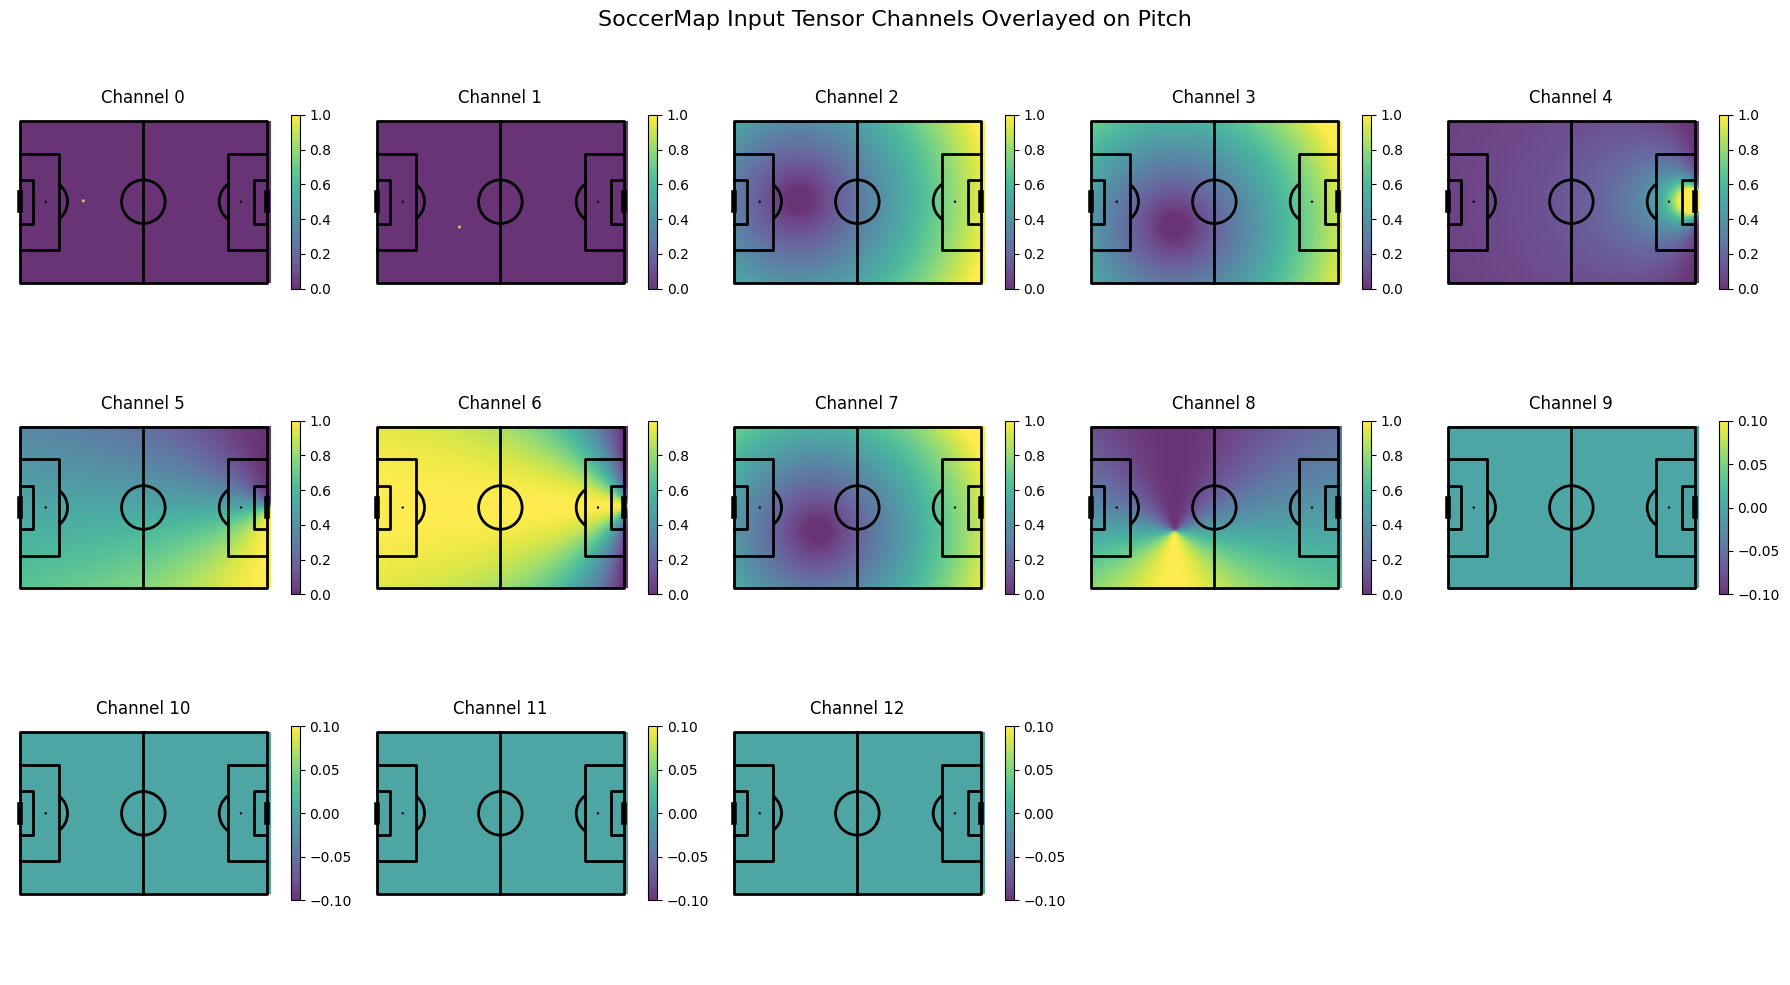

In [187]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# sample one tensor from dataset
x, mask, y = dataset[100]
#pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
pitch = Pitch(
    pitch_type='custom',
    pitch_length=104,  # from -52 to +52
    pitch_width=68,    # from -34 to +34
    pitch_color='white',
    line_color='black'
)

# Create figure with 13 channels
fig, axes = plt.subplots(3, 5, figsize=(18, 10))
axes = axes.flatten()

for i in range(13):
    ax = axes[i]
    pitch.draw(ax=ax)
    im = ax.imshow(
        x[i].numpy(),
        extent=[0, 105, 0, 68],      # align to real pitch scale
        origin='lower',
        cmap='viridis',
        alpha=0.8
    )
    ax.set_title(f"Channel {i}")
    fig.colorbar(im, ax=ax, fraction=0.03)

# Hide unused subplots (since we only have 13)
for j in range(13, len(axes)):
    axes[j].axis('off')

plt.suptitle("SoccerMap Input Tensor Channels Overlayed on Pitch", fontsize=16)
plt.tight_layout()
plt.show()


## Define the SoccerMap Architecture

First, we define a compact CNN-based spatial encoder–decoder (“SoccerMap”) that outputs a single probability surface.

In [188]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC

import torch
import torch.nn as nn

# class SoccerMap(nn.Module):
#     def __init__(self, in_channels=13):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels, 32, 3, padding=1),
#             nn.GroupNorm(4, 32),   # 🔄 safer than BatchNorm for sparse inputs
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.GroupNorm(8, 64),
#             nn.ReLU(inplace=True),
#             #nn.AdaptiveAvgPool2d((1, 1)),  # global pooling
#         )
#         self.head = nn.Linear(64, 1)

#     def forward(self, x):
#         # safety guards
#         x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
#         x = torch.clamp(x, -1.0, 1.0)
#         x = self.encoder(x)
#         x = x.view(x.size(0), -1)
#         x = self.head(x)
#         return x


In [189]:
class SoccerMap(nn.Module):
    def __init__(self, in_channels=13):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1), #in_channels=13 → we start with 13 input maps , 32 → we create 32 new feature maps (kind of like “pattern detectors”), 3 → means each filter looks at a 3×3 neighborhood of the pitch
                #padding=1 → makes sure the output size stays the same (68×105)
                #So after this layer, you now have 32 different filtered views of the pitch, each focusing on a different spatial pattern (like “crowded zones”, “forward passing directions”, etc.).
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # This applies a simple rule to all numbers: If it’s positive → keep it, If it’s negative → make it zero.
            # This helps the network learn non-linear relationships (real-world football dynamics are not linear).
            # ⚠️ Removed AdaptiveAvgPool2d
        )
        self.head = nn.Conv2d(64, 1, kernel_size=1)  # predict 1 channel per pixel
        # This final layer compresses those 64 learned patterns down to 1 map —a single heatmap where each cell says: “How likely is a successful pass here?”
        # kernel_size=1 → means it looks at one cell at a time, combining the 64 features linearly.

    def forward(self, x):
        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        x = torch.clamp(x, -1.0, 1.0)
        x = self.encoder(x) # Extracts useful patterns about field context, positioning, etc.
        x = self.head(x) #Produces one final map = “probability of pass success per cell”.
        return x  # shape: [B, 1, 68, 105]


In [190]:
model = SoccerMap()
x, mask, y = next(iter(train_loader))
x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
x = torch.clamp(x, -1.0, 1.0)

with torch.no_grad():
    out = model(x)

print("Output min/max:", out.min().item(), out.max().item())
print("Any NaNs in output:", torch.isnan(out).any().item())


Output min/max: -1.5374884605407715 2.389995813369751
Any NaNs in output: False


## Define the Lightning Module for Training

This wraps the model, handles forward pass, loss calculation, and logging.


This class is a wrapper around our SoccerMap neural network that:

- Knows how to train the model

- Knows how to validate and log metrics

- Knows what optimizer and loss function to use

It’s built using a library called PyTorch Lightning, which automates most of the painful parts of training (like looping over batches, logging metrics, saving checkpoints, etc.).

### What is a LightningModule?

A LightningModule is like a trainer’s manual for our neural network.
It defines everything PyTorch Lightning needs to know to run the model end-to-end:

| Component              | Purpose                                   |
| ---------------------- | ----------------------------------------- |
| `__init__`             | Set up your model, loss, and metrics      |
| `forward`              | Defines how data passes through the model |
| `training_step`        | What to do for each batch in training     |
| `validation_step`      | What to do for each batch in validation   |
| `configure_optimizers` | Tells Lightning which optimizer to use    |


In [191]:
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl

class PytorchSoccerMapModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.save_hyperparameters() # saves lr=1e-4 automatically, so it’s logged and checkpointed.

        # --- Core SoccerMap CNN ---
        self.model = SoccerMap(in_channels=13)

        # --- Loss & Metrics ---
        self.criterion = nn.BCEWithLogitsLoss() # The main training objective — compares predictions vs. true labels (0 or 1). It’s a binary cross-entropy loss that expects raw outputs (logits) from the model.
        self.train_acc = torchmetrics.classification.BinaryAccuracy() # How often the model’s prediction is correct (above or below 0.5).
        self.train_auc = torchmetrics.classification.BinaryAUROC() # Measures how well the model ranks positives above negatives — more robust than accuracy for imbalanced data.
        self.val_acc = torchmetrics.classification.BinaryAccuracy()
        self.val_auc = torchmetrics.classification.BinaryAUROC()
        
    def on_train_start(self):
        print(f"🚀 Training on device: {self.device}")
        # Si tu veux logguer la mémoire GPU :
        if self.device.type == "cuda":
            print(f"🔋 GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

    def forward(self, x):
        """Forward pass through CNN to get full surface logits. “To make a prediction, pass the input x through the CNN.”"""
        return self.model(x)  # [B, 1, 68, 105]

    def shared_step(self, batch, stage="train"):
        x, mask, y = batch
        logits = self(x)  # [B, 1, 68, 105] runs the CNN to produce the surface logits (raw values before sigmoid).

        # --- Apply mask to reduce spatial logits to one scalar per sample ---
        masked_logits = (logits * mask).sum(dim=(2, 3))  # [B, 1]
        """extracts only the predicted value at the pass destination cell.
        The rest of the pitch is ignored (set to zero).
        The sum effectively collapses the spatial surface into a single scalar prediction per sample.
        So now you’ve gone from [B, 1, 68, 105] → [B, 1]."""

        # --- Compute loss ---
        loss = self.criterion(masked_logits, y)

        # --- Compute metrics ---
        probs = torch.sigmoid(masked_logits) # sigmoid converts raw numbers into probabilities (0–1 range).
        acc = self.train_acc(probs, y.int()) if stage == "train" else self.val_acc(probs, y.int())
        auc = self.train_auc(probs, y.int()) if stage == "train" else self.val_auc(probs, y.int())

        # --- Logging ---
        self.log(f"{stage}/loss", loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}/acc", acc, prog_bar=True, on_epoch=True)
        self.log(f"{stage}/auc", auc, prog_bar=True, on_epoch=True)
        """Lightning handles logging automatically — these values will appear in your progress bar and epoch summaries."""

        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, stage="val")
    
    def on_train_epoch_end(self):
        loss = self.trainer.callback_metrics.get("train/loss_epoch")
        acc = self.trainer.callback_metrics.get("train/acc_epoch")
        auc = self.trainer.callback_metrics.get("train/auc_epoch")
        print(f"🧠 Epoch {self.current_epoch} — TRAIN | loss: {loss:.4f}, acc: {acc:.4f}, auc: {auc:.4f}")

    def on_validation_epoch_end(self):
        loss = self.trainer.callback_metrics.get("val/loss")
        acc = self.trainer.callback_metrics.get("val/acc")
        auc = self.trainer.callback_metrics.get("val/auc")
        print(f"🎯 Epoch {self.current_epoch} — VAL | loss: {loss:.4f}, acc: {acc:.4f}, auc: {auc:.4f}")


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr) # The optimizer updates all model parameters based on gradients from the loss function.


In [192]:
x, mask, y = next(iter(train_loader))
x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
x = torch.clamp(x, -1.0, 1.0)

with torch.no_grad():
    out = model(x)

print("Output min/max:", out.min().item(), out.max().item())
print("Any NaNs in output:", torch.isnan(out).any().item())


Output min/max: -1.183772325515747 2.2974257469177246
Any NaNs in output: False


## During Prediction (Inference)

Once the model is trained, we don’t apply the mask anymore.

Instead, we let it freely output its full [1, 68, 105] probability surface.

You can think of it as:

“Okay model — forget the true pass.
Tell me what you think the probability of success would be
from every single location on the pitch.”

In [193]:
model.eval()
with torch.no_grad():
    logits = model(x)              # [1, 1, 68, 105]
    probs = torch.sigmoid(logits)  # convert to 0–1 range

print(probs.shape)
print("logits:", logits[:10].flatten())
print("probs:", probs[:10].flatten())
print("labels:", y.flatten())

torch.Size([16, 1, 68, 105])
logits: tensor([ 0.0510,  0.0858,  0.0821,  ..., -0.0016, -0.0043,  0.0003])
probs: tensor([0.5127, 0.5214, 0.5205,  ..., 0.4996, 0.4989, 0.5001])
labels: tensor([0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.])


- x contains the 13-channel context for that frame (positions, directions, etc.)

- model(x) outputs one logit per pitch cell

- After applying sigmoid, each cell now holds a predicted probability

  The result is a full heatmap of success likelihood across the pitch.

In [ ]:
# ---- GRADIENT SANITY CHECK ----
model = SoccerMap()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

x, mask, y = next(iter(train_loader))

# Clean input
x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
x = torch.clamp(x, -1.0, 1.0)

x.requires_grad_(True)

# Forward pass
logits = model(x)                # [B, 1, 68, 105]
masked_logits = (logits * mask).sum(dim=(2, 3))  # [B, 1]

# Compute loss
loss = criterion(masked_logits, y)

# Backward pass
optimizer.zero_grad()
loss.backward()

# Compute gradient magnitude
max_grad = max(p.grad.abs().max().item() for p in model.parameters() if p.grad is not None)

print(f"Loss: {loss.item():.6f}, Max Grad: {max_grad:.6f}")
print("Any NaNs in logits?", torch.isnan(masked_logits).any().item())
print("Any NaNs in loss?", torch.isnan(loss).any().item())


## Run trainer with validation logging

In [196]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath="/tmp/checkpoints",  # dossier temporaire local
    filename="soccermap_{epoch:02d}-{val/loss:.4f}",
    save_top_k=1,                # conserve le meilleur modèle
    monitor="val/loss",
    mode="min"
)

In [ ]:
model = PytorchSoccerMapModel(lr=1e-4)

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision=16,
    callbacks=[checkpoint_callback],
    log_every_n_steps=10,
)

trainer.fit(model, train_loader, val_loader)




Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | SoccerMap         | 22.5 K | train
1 | criterion | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | train_auc | BinaryAUROC       | 0      | train
4 | val_acc   | BinaryAccuracy    | 0      | train
5 | val_auc   | BinaryAUROC       | 0      | train
--------------------------------------------------------
22.5 K    Trainable params
0         Non-trainable params
22.5 K    Total params
0.090     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

🎯 Epoch 0 — VAL | loss: 0.6968, acc: 0.2578, auc: 0.4638


Training: |          | 0/? [00:00<?, ?it/s]

🚀 Training on device: cuda:0
🔋 GPU memory allocated: 49.71 MB


In [50]:
best_ckpt_path = "/tmp/checkpoints/soccer_map_epoch=04-val/loss=0.6111.ckpt"

model = PytorchSoccerMapModel.load_from_checkpoint(best_ckpt_path)
model.eval()

PytorchSoccerMapModel(
  (model): SoccerMap(
    (encoder): Sequential(
      (0): Conv2d(13, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (head): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (criterion): BCEWithLogitsLoss()
  (train_acc): BinaryAccuracy()
  (train_auc): BinaryAUROC()
  (val_acc): BinaryAccuracy()
  (val_auc): BinaryAUROC()
)

In [54]:
checkpoint_callback.best_model_path

'/tmp/checkpoints/soccer_map_epoch=04-val/loss=0.6111.ckpt'

In [57]:
src = checkpoint_callback.best_model_path
dst = "gs://arthur_tmp/soccermap_model/best.ckpt"

with fs.open(dst, "wb") as gcs_f:
    with open(src, "rb") as f:
        shutil.copyfileobj(f, gcs_f)

print("Uploaded:", dst)

Uploaded: gs://arthur_tmp/soccermap_model/best.ckpt


In [53]:
x = next(iter(val_loader))[0]
with torch.no_grad():
    y_pred = model(x)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [58]:
metrics = trainer.logged_metrics
metrics


{'train/loss_step': tensor(0.6343),
 'train/acc_step': tensor(0.6250),
 'train/auc_step': tensor(0.7044),
 'val/loss': tensor(0.6111),
 'val/acc': tensor(0.6605),
 'val/auc': tensor(0.7244),
 'train/loss_epoch': tensor(0.6118),
 'train/acc_epoch': tensor(0.6595),
 'train/auc_epoch': tensor(0.7235)}

In [60]:
ys = []
for _, _, y in train_loader:
    ys.extend(y.numpy().flatten().tolist())
print(pd.Series(ys).value_counts(normalize=True))



KeyboardInterrupt: 

In [62]:
x, mask, y = next(iter(train_loader))
print("Per-channel mean:", x.view(x.size(1), -1).mean(dim=1))
print("Per-channel std:", x.view(x.size(1), -1).std(dim=1))


Per-channel mean: tensor([0.2702, 0.2717, 0.2720, 0.2659, 0.2645, 0.2666, 0.2750, 0.2835, 0.2679,
        0.2616, 0.2670, 0.2628, 0.2711])
Per-channel std: tensor([0.3350, 0.3360, 0.3399, 0.3356, 0.3351, 0.3351, 0.3391, 0.3436, 0.3359,
        0.3320, 0.3358, 0.3350, 0.3359])


In [70]:
dataset.df

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,...,team_in_possession_shortname,attacking_side,x_start_rescaled,y_start_rescaled,x_end_rescaled,y_end_rescaled,lead_to_goal,lead_to_shot,label,success
0,2005041,01:00:22.70,36947,2,24614,False,False,9.68,-14.02,62.273077,...,Arsenal,left_to_right,31.086058,60.76,36.507692,59.36,False,False,1.0,1.0
1,2017699,00:45:44.70,27457,1,17969,True,False,15.92,-33.20,36.426923,...,Fulham,right_to_left,27.653365,51.05,28.148077,50.39,False,False,1.0,1.0
2,1901786,00:30:48.60,18496,1,30621,True,False,-16.11,-23.09,36.235096,...,Leicester,left_to_right,13.831731,9.42,12.408173,12.05,False,False,1.0,1.0
3,1939716,00:07:02.70,4237,1,117220,True,False,-33.51,-0.96,18.667788,...,Leicester,left_to_right,28.683173,46.46,28.683173,46.46,False,False,1.0,1.0
4,2007863,00:09:41.60,5826,1,11557,False,False,35.93,-0.76,88.775481,...,Leicester,left_to_right,28.148077,25.39,28.148077,25.39,False,False,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566476,2018580,01:34:19.60,57536,2,32927,True,False,-46.68,-7.84,99.628846,...,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0,0.0
2566477,2018580,01:34:19.60,57536,2,33678,True,False,-40.21,0.94,93.096635,...,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0,0.0
2566478,2018580,01:34:19.60,57536,2,59889,True,False,-50.16,-1.11,103.142308,...,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0,0.0
2566479,2018580,01:34:19.60,57536,2,173693,True,False,-49.56,-0.83,102.536538,...,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0,0.0


In [65]:
best_ckpt_path = "/tmp/checkpoints/soccer_map_epoch=04-val/loss=0.6111.ckpt"
model = PytorchSoccerMapModel.load_from_checkpoint(best_ckpt_path)

model.eval()
model = model.to("cuda")

x, mask, y = dataset[450]
x = x.unsqueeze(0).to("cuda")

model.eval()
with torch.no_grad():
    logits = model(x)
    probs = torch.sigmoid(logits)[0, 0].cpu().numpy()

In [71]:
probs.shape

(68, 105)

## Visualization

In [74]:
dataset.df.shape

(2566481, 38)

In [73]:
balanced_df.shape

(2566481, 37)

In [75]:
normed_all = balanced_df.copy()

In [82]:
balanced_df

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,...,team_in_possession,team_in_possession_shortname,attacking_side,x_start_rescaled,y_start_rescaled,x_end_rescaled,y_end_rescaled,lead_to_goal,lead_to_shot,label
0,2005041,01:00:22.70,36947,2,24614,False,False,9.68,-14.02,62.273077,...,3,Arsenal,left_to_right,31.086058,60.76,36.507692,59.36,False,False,1.0
1,2017699,00:45:44.70,27457,1,17969,True,False,15.92,-33.20,36.426923,...,48,Fulham,right_to_left,27.653365,51.05,28.148077,50.39,False,False,1.0
2,1901786,00:30:48.60,18496,1,30621,True,False,-16.11,-23.09,36.235096,...,62,Leicester,left_to_right,13.831731,9.42,12.408173,12.05,False,False,1.0
3,1939716,00:07:02.70,4237,1,117220,True,False,-33.51,-0.96,18.667788,...,62,Leicester,left_to_right,28.683173,46.46,28.683173,46.46,False,False,1.0
4,2007863,00:09:41.60,5826,1,11557,False,False,35.93,-0.76,88.775481,...,62,Leicester,left_to_right,28.148077,25.39,28.148077,25.39,False,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566476,2018580,01:34:19.60,57536,2,32927,True,False,-46.68,-7.84,99.628846,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566477,2018580,01:34:19.60,57536,2,33678,True,False,-40.21,0.94,93.096635,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566478,2018580,01:34:19.60,57536,2,59889,True,False,-50.16,-1.11,103.142308,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566479,2018580,01:34:19.60,57536,2,173693,True,False,-49.56,-0.83,102.536538,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0


In [91]:
balanced_df.groupby(['match_id', 'frame']).count()

time  period  player_id  is_detected  is_ball   x   y  \
match_id frame                                                          
1650385  52        6       6          6            6        6   6   6   
         62        6       6          6            6        6   6   6   
         87        4       4          4            4        4   4   4   
         160       3       3          3            3        3   3   3   
         655       5       5          5            5        5   5   5   
...              ...     ...        ...          ...      ...  ..  ..   
2018580  57024    23      23         23           23       23  23  23   
         57042    23      23         23           23       23  23  23   
         57090    23      23         23           23       23  23  23   
         57536    23      23         23           23       23  23  23   
         57540     3       3          3            3        3   3   3   

                x_rescaled  y_rescaled  time_s  ...  team_in_possession  \
match_id frame                                  ...                       
1650385  52              6           6       6  ...                   6   
         62              6           6       6  ...                   6   
         87              4           4       4  ...                   4   
         160             3           3       3  ...                   3   
         655             5           5       5  ...                   5   
...                    ...         ...     ...  ...                 ...   
2018580  57024          23          23      23  ...                  23   
         57042          23          23      23  ...                  23   
         57090          23          23      23  ...                  23   
         57536          23          23      23  ...                  23   
         57540           3           3       3  ...                   3   

                team_in_possession_shortname  attacking_side  \
match_id frame                                                 
1650385  52                                6               6   
         62                                6               6   
         87                                4               4   
         160                               3               3   
         655                               5               5   
...                                      ...             ...   
2018580  57024                            23              23   
         57042                            23              23   
         57090                            23              23   
         57536                            23              23   
         57540                             3               3   

                x_start_rescaled  y_start_rescaled  x_end_rescaled  \
match_id frame                                                       
1650385  52                    6                 6               6   
         62                    6                 6               6   
         87                    4                 4               4   
         160                   3                 3               3   
         655                   5                 5               5   
...                          ...               ...             ...   
2018580  57024                23                23              23   
         57042                23                23              23   
         57090                23                23              23   
         57536                23                23              23   
         57540                 3                 3               3   

                y_end_rescaled  lead_to_goal  lead_to_shot  label  
match_id frame                                                     
1650385  52                  6             6             6      6  
         62                  6             6             6      6  
         87                  4             4             4      4  
      

In [93]:
counts = balanced_df.groupby(["match_id", "frame"]).size()       # nombre de rows par match_id x frame
counts.value_counts() 

4     54259
5     53878
23    53196
3     41992
6     41678
7     26304
2     23249
8     13651
1      8105
9      5817
22     2119
10     2117
11      701
12      180
21       86
13       35
20       11
14        4
15        1
Name: count, dtype: int64

In [83]:
balanced_df[(balanced_df.match_id == 2018580)&(balanced_df.frame == 57536)]

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,...,team_in_possession,team_in_possession_shortname,attacking_side,x_start_rescaled,y_start_rescaled,x_end_rescaled,y_end_rescaled,lead_to_goal,lead_to_shot,label
2566458,2018580,01:34:19.60,57536,2,11418,False,False,-49.24,5.02,102.213462,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566459,2018580,01:34:19.60,57536,2,11454,True,False,-51.02,3.51,104.010577,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566460,2018580,01:34:19.60,57536,2,12012,True,False,-49.72,5.44,102.698077,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566461,2018580,01:34:19.60,57536,2,12577,True,False,-48.76,8.03,101.728846,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566462,2018580,01:34:19.60,57536,2,12629,False,False,-33.10,6.39,85.918269,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566463,2018580,01:34:19.60,57536,2,13368,True,False,-47.30,0.30,100.254808,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566464,2018580,01:34:19.60,57536,2,13924,False,False,-42.90,-30.30,95.812500,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566465,2018580,01:34:19.60,57536,2,14488,True,False,-46.78,-1.10,99.729808,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566466,2018580,01:34:19.60,57536,2,16322,True,False,-48.05,9.16,101.012019,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0
2566467,2018580,01:34:19.60,57536,2,16381,True,False,-49.48,-2.58,102.455769,...,754,Brentford FC,right_to_left,101.486538,26.52,101.486538,26.52,False,False,0.0


In [79]:
frame_df

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,...,team_in_possession,team_in_possession_shortname,attacking_side,x_start_rescaled,y_start_rescaled,x_end_rescaled,y_end_rescaled,lead_to_goal,lead_to_shot,label
100,1815119,00:33:02.00,19830,1,23126,True,False,-3.29,34.30,49.178365,...,62,Leicester,left_to_right,58.547596,66.44,57.850962,66.7,False,False,1.0
609868,1815119,00:33:02.00,19830,1,12113,True,False,-6.53,2.88,45.907212,...,62,Leicester,left_to_right,58.547596,66.44,57.850962,66.7,False,False,1.0
630979,1815119,00:33:02.00,19830,1,-1,True,True,4.74,31.81,57.285577,...,62,Leicester,left_to_right,58.547596,66.44,57.850962,66.7,False,False,1.0
703597,1815119,00:33:02.00,19830,1,24688,True,False,9.92,17.75,62.515385,...,62,Leicester,left_to_right,58.547596,66.44,57.850962,66.7,False,False,1.0
1246471,1815119,00:33:02.00,19830,1,7285,False,False,40.91,4.02,93.803365,...,62,Leicester,left_to_right,58.547596,66.44,57.850962,66.7,False,False,1.0


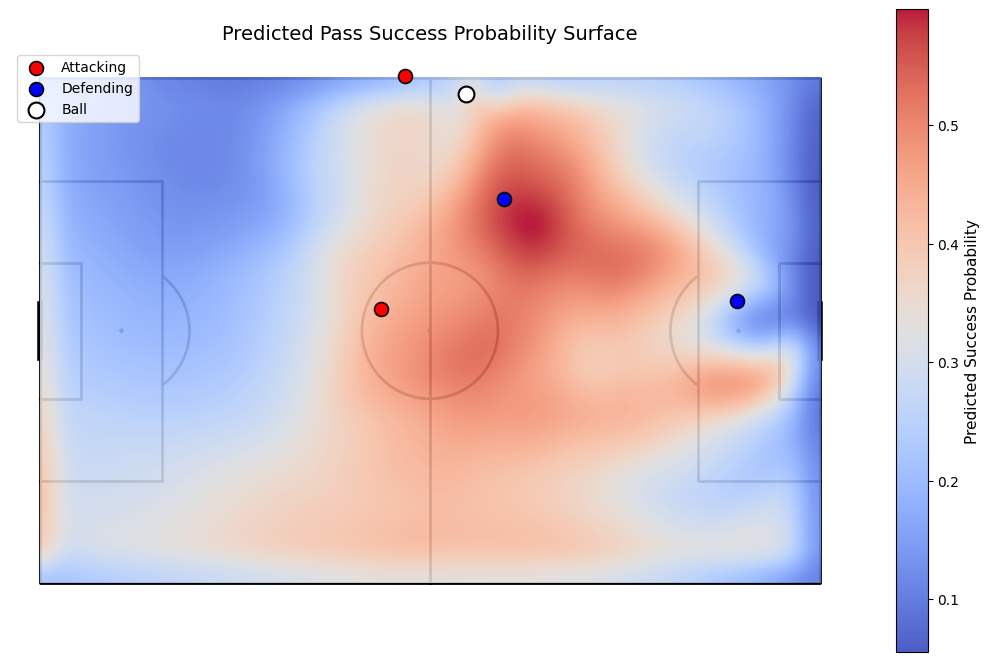

In [78]:
import torch
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
from scipy.ndimage import gaussian_filter

# --- 1️⃣ Get model output ---
x, mask, y = dataset[100]
#x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
x = x.unsqueeze(0).to("cuda")

model.eval()
model = model.to("cuda")
with torch.no_grad():
    logits = model(x)
    probs = torch.sigmoid(logits)[0, 0].cpu().numpy()  # shape (68, 105)

# --- 2️⃣ Smooth the probability surface ---
probs_smooth = gaussian_filter(probs, sigma=2)  # try sigma=1.5–3 for different smoothness levels

# --- 3️⃣ Get frame (for player and ball positions) ---
row = dataset.df.iloc[100]
match_id = row["match_id"]
frame = row["frame"]
frame_df = normed_all.query("match_id == @match_id and frame == @frame")

# --- 4️⃣ Separate players and ball ---
attacking_team = row["team_in_possession"]
att = frame_df[frame_df["team_id"] == attacking_team]
defn = frame_df[(frame_df["team_id"] != attacking_team) & (~frame_df["is_ball"])]
ball = frame_df[frame_df["is_ball"]]

# --- 5️⃣ Pitch setup ---
pitch = Pitch(
    pitch_type='custom',
    pitch_length=105, pitch_width=68,
    pitch_color='white',
    line_color='black'
)
fig, ax = pitch.draw(figsize=(10, 7))

# --- 6️⃣ Plot the smoothed heatmap ---
im = ax.imshow(
    probs_smooth,
    extent=[0, 105, 0, 68],
    origin='lower',
    cmap='coolwarm',            # 🔥 blue-to-red
    alpha=0.9,
    interpolation='bilinear',   # 🔥 smoother visual
    zorder=1
)

# --- 7️⃣ Overlay players and ball ---
ax.scatter(att["x_rescaled"], att["y_rescaled"],
           s=100, c='red', edgecolors='black', linewidth=1.2, label='Attacking', zorder=3)
ax.scatter(defn["x_rescaled"], defn["y_rescaled"],
           s=100, c='blue', edgecolors='black', linewidth=1.2, label='Defending', zorder=3)
ax.scatter(ball["x_rescaled"], ball["y_rescaled"],
           s=130, c='white', edgecolors='black', linewidth=1.5, marker='o', label='Ball', zorder=4)

# --- 8️⃣ Final styling ---
cbar = fig.colorbar(im, ax=ax, fraction=0.035)
cbar.set_label('Predicted Success Probability', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
plt.title("Predicted Pass Success Probability Surface", fontsize=14)
plt.tight_layout()
plt.show()


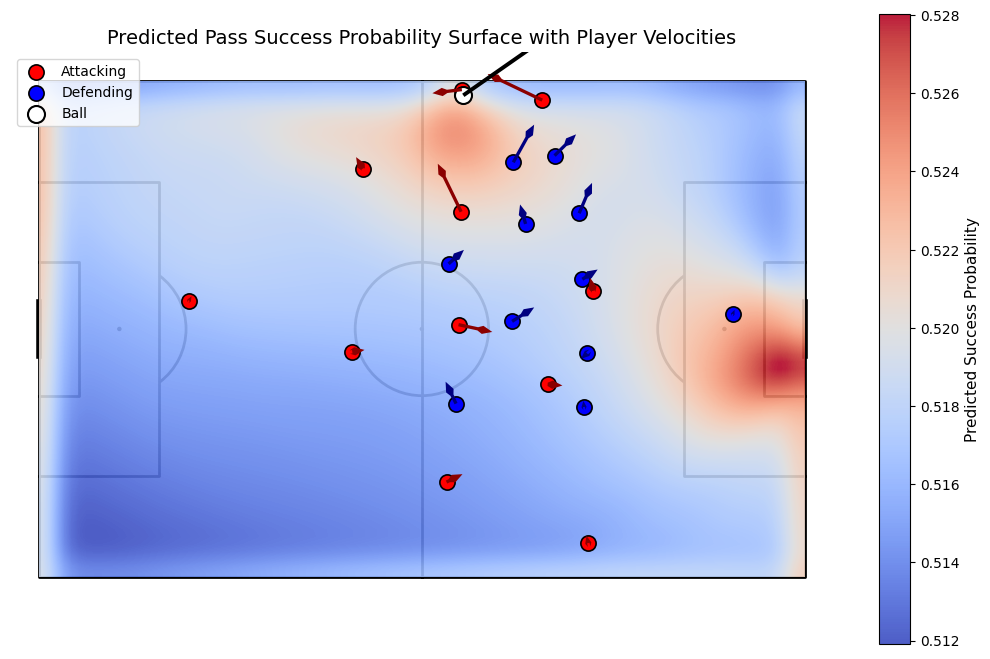

In [706]:
import torch
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
from scipy.ndimage import gaussian_filter

# --- 1️⃣ Get model output ---
x, mask, y = dataset[25]
x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)

model.eval()
with torch.no_grad():
    logits = model(x)
    probs = torch.sigmoid(logits)[0, 0].cpu().numpy()  # shape (68, 105)

# --- 2️⃣ Smooth the probability surface ---
probs_smooth = gaussian_filter(probs, sigma=2)

# --- 3️⃣ Get frame (for player and ball positions) ---
row = dataset.df.iloc[25]
match_id = row["match_id"]
frame = row["frame"]
frame_df = normed_all.query("match_id == @match_id and frame == @frame")

# --- 4️⃣ Separate players and ball ---
attacking_team = row["team_in_possession"]
att = frame_df[frame_df["team_id"] == attacking_team]
defn = frame_df[(frame_df["team_id"] != attacking_team) & (~frame_df["is_ball"])]
ball = frame_df[frame_df["is_ball"]]

# --- 5️⃣ Pitch setup ---
pitch = Pitch(
    pitch_type='custom',
    pitch_length=105, pitch_width=68,
    pitch_color='white',
    line_color='black'
)
fig, ax = pitch.draw(figsize=(10, 7))

# --- 6️⃣ Plot the smoothed heatmap ---
im = ax.imshow(
    probs_smooth,
    extent=[0, 105, 0, 68],
    origin='lower',
    cmap='coolwarm',
    alpha=0.9,
    interpolation='bilinear',
    zorder=1
)

# --- 7️⃣ Overlay players and ball ---
ax.scatter(att["x_rescaled"], att["y_rescaled"],
           s=120, c='red', edgecolors='black', linewidth=1.2, label='Attacking', zorder=3)
ax.scatter(defn["x_rescaled"], defn["y_rescaled"],
           s=120, c='blue', edgecolors='black', linewidth=1.2, label='Defending', zorder=3)
ax.scatter(ball["x_rescaled"], ball["y_rescaled"],
           s=150, c='white', edgecolors='black', linewidth=1.5, marker='o', label='Ball', zorder=4)

# --- 8️⃣ Add velocity arrows (larger & clearer) ---
arrow_scale = 0.4     # smaller = longer arrows (try 0.3–0.6)
arrow_width = 0.004   # thicker lines
head_width = 2.5
head_length = 3.0

# Attacking team velocities
ax.quiver(
    att["x_rescaled"], att["y_rescaled"],
    att["vx_mps"], att["vy_mps"],
    color='darkred', angles='xy', scale_units='xy',
    scale=arrow_scale, width=arrow_width,
    headwidth=head_width, headlength=head_length,
    zorder=4
)

# Defending team velocities
ax.quiver(
    defn["x_rescaled"], defn["y_rescaled"],
    defn["vx_mps"], defn["vy_mps"],
    color='navy', angles='xy', scale_units='xy',
    scale=arrow_scale, width=arrow_width,
    headwidth=head_width, headlength=head_length,
    zorder=4
)

# Ball velocity (larger arrow)
if not ball.empty:
    ax.quiver(
        ball["x_rescaled"], ball["y_rescaled"],
        ball["vx_mps"], ball["vy_mps"],
        color='black', angles='xy', scale_units='xy',
        scale=arrow_scale * 0.5, width=arrow_width * 1.2,
        headwidth=head_width * 1.5, headlength=head_length * 1.5,
        zorder=5
    )

# --- 9️⃣ Final styling ---
cbar = fig.colorbar(im, ax=ax, fraction=0.035)
cbar.set_label('Predicted Success Probability', fontsize=11)
ax.legend(loc='upper left', fontsize=10)
plt.title("Predicted Pass Success Probability Surface with Player Velocities", fontsize=14)
plt.tight_layout()
plt.show()


# xT (value) surface:


We are now moving from pass success probability → expected threat (xT) estimation 

This means:

- We keep almost all your existing pipeline (SoccerMap, transforms, training loop, visualization).

- We only change the dataset’s label logic so that instead of predicting pass_outcome, we predict whether a pass eventually leads to a goal (lead_to_goal == True).

- After training, we can generate a pitch-wide xT map, where each cell represents probability of leading to a goal given a pass from that location.

## Question: 
“If a pass ends at this zone on the pitch, what’s the probability it eventually leads to a goal?”